In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Modeller
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
import pandas as pd


phishing_data = pd.read_csv('phishing.csv')
print(len(phishing_data))

umbrella_data = pd.read_csv('umbrella_top_1m.csv', names=['rank', 'domain'])

55405


In [3]:
from urllib.parse import urlparse


def extract_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return domain

phishing_data['domain'] = phishing_data['url'].apply(extract_domain)


In [4]:
phishing_data['label'] = 1
umbrella_data['label'] = 0

In [5]:
import pandas as pd

# Phishing veri setinden 2000 adet rastgele örnek seçme
phishing_samples = phishing_data.sample(n=3000, random_state=42)

# Umbrella veri setinden ilk 2000 veriyi alma
umbrella_samples = umbrella_data.iloc[:3000]

# İki veri setini birleştirme
balanced_data = pd.concat([phishing_samples[['domain', 'label']], umbrella_samples[['domain', 'label']]], ignore_index=True)

# Veri setini karıştırma
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Sonuçların uzunluğunu yazdırma
print(len(balanced_data))

6000


In [6]:
missing_data = balanced_data.isnull().sum()
print("Eksik Veri Analizi:")
print(missing_data)

Eksik Veri Analizi:
domain    0
label     0
dtype: int64


In [7]:
# Assuming X_train is a NumPy array
print(balanced_data[:5])

                      domain  label
0         fi4tfn.webwave.dev      1
1  suggestqueries.google.com      0
2                    ipfs.io      1
3    ipfs.eth.aragon.network      1
4   3-courier.push.apple.com      0


In [8]:
# balanced_data'yı bir csv olarak kaydetme
balanced_data.to_csv('balanced_data.csv', index=False)

print("balanced_data.csv dosyası başarıyla kaydedildi.")

balanced_data.csv dosyası başarıyla kaydedildi.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X = vectorizer.fit_transform(balanced_data['domain'])
y = balanced_data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  
    tnr = tn / (tn + fp)  

 
    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    # Performans Metriklerini Yazdır
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

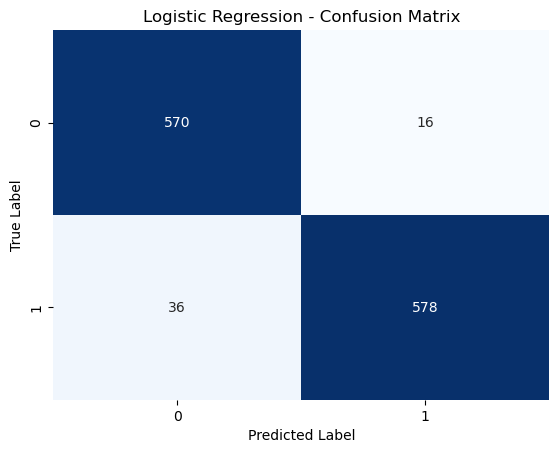

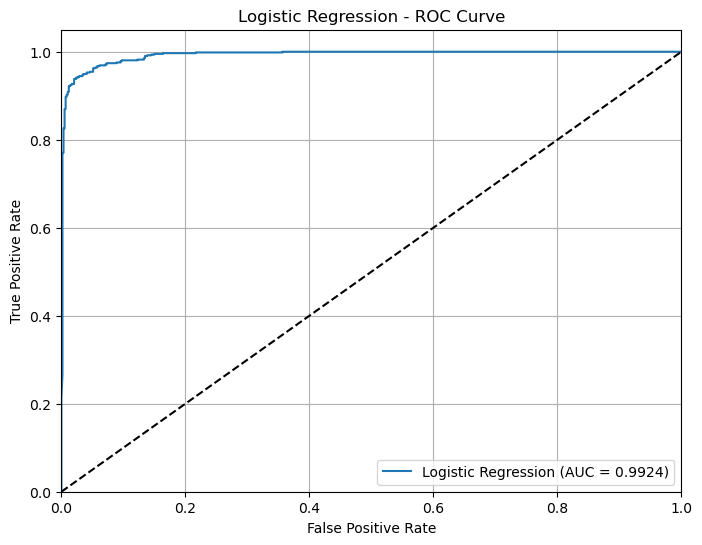

Logistic Regression Performance:
Accuracy: 0.96
Precision: 0.97
Recall (TPR): 0.94
TNR (Specificity): 0.97
F1 Score: 0.96



In [12]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, 'Logistic Regression', logistic_model, X_test)

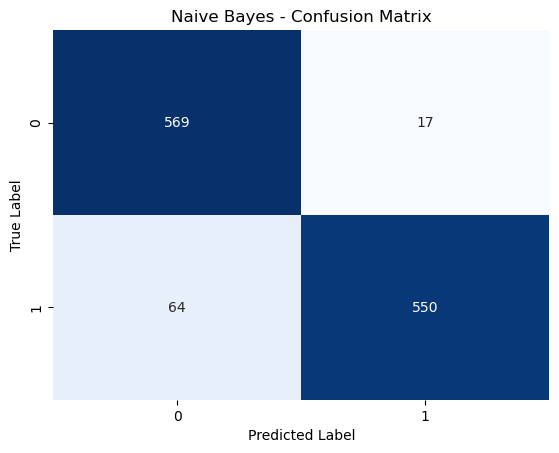

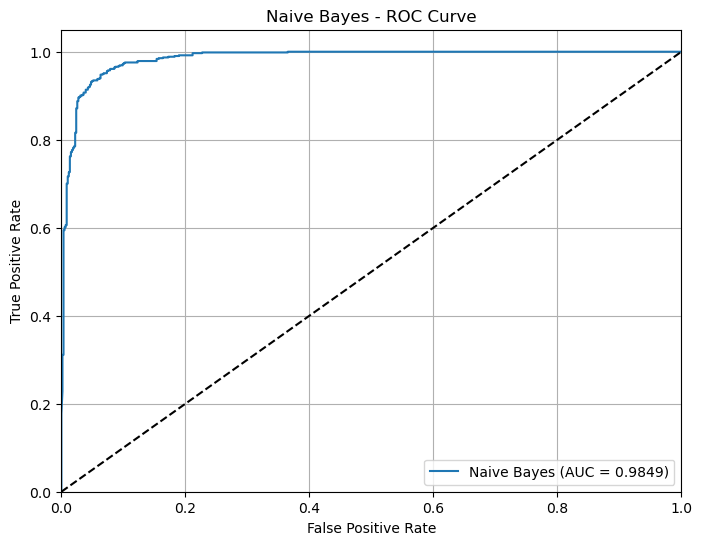

Naive Bayes Performance:
Accuracy: 0.93
Precision: 0.97
Recall (TPR): 0.90
TNR (Specificity): 0.97
F1 Score: 0.93



In [13]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_metrics = evaluate_model(y_test, y_pred_nb, 'Naive Bayes', nb_model, X_test)

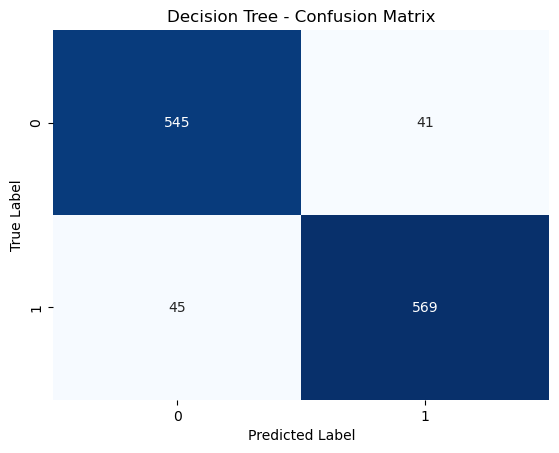

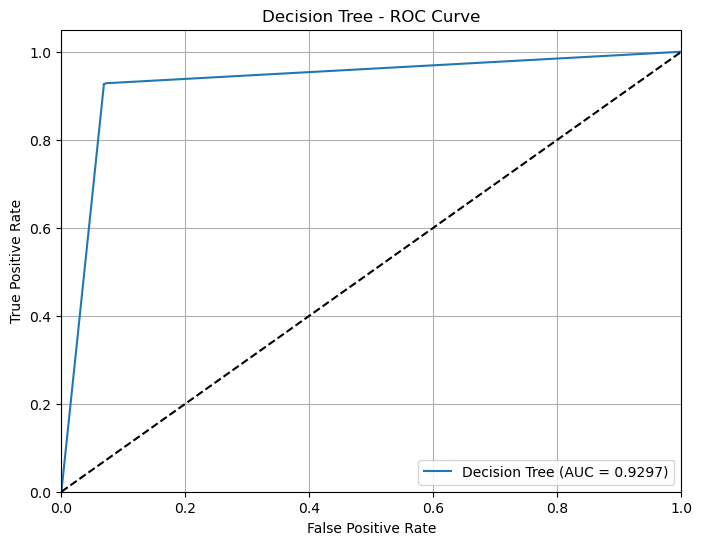

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.93
TNR (Specificity): 0.93
F1 Score: 0.93



In [14]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree', dt_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


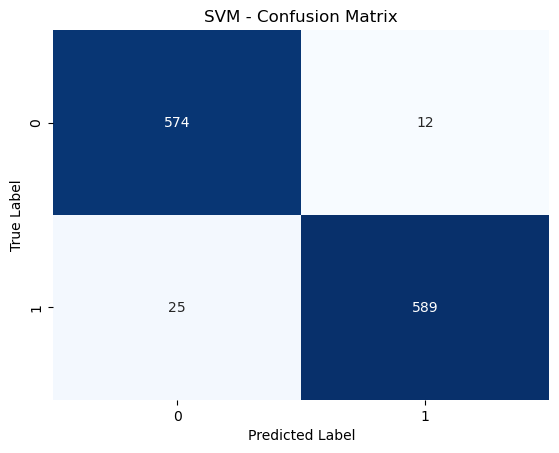

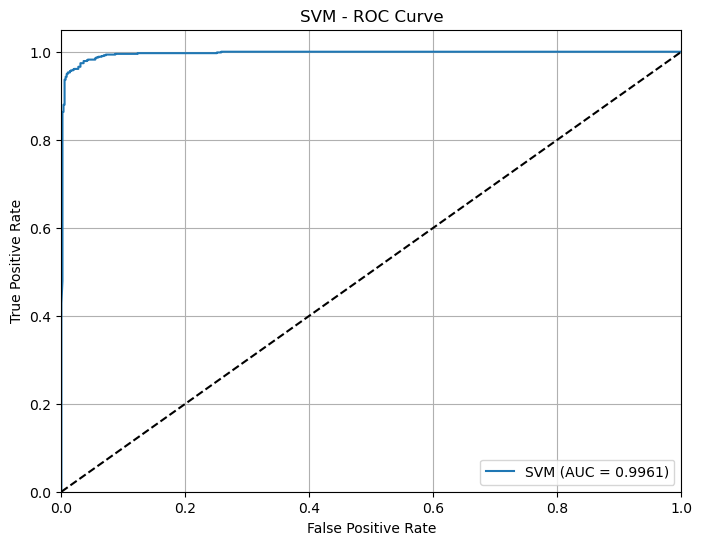

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [15]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM', svm_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


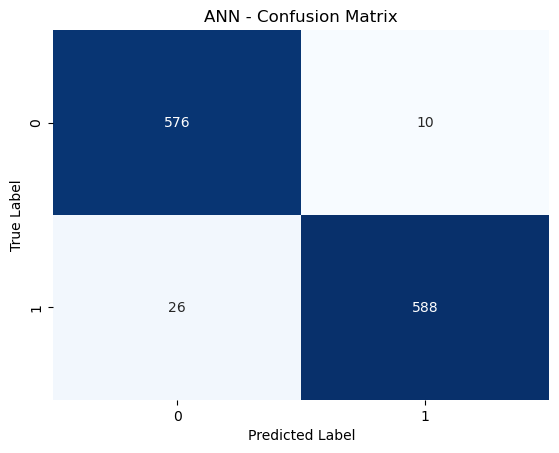

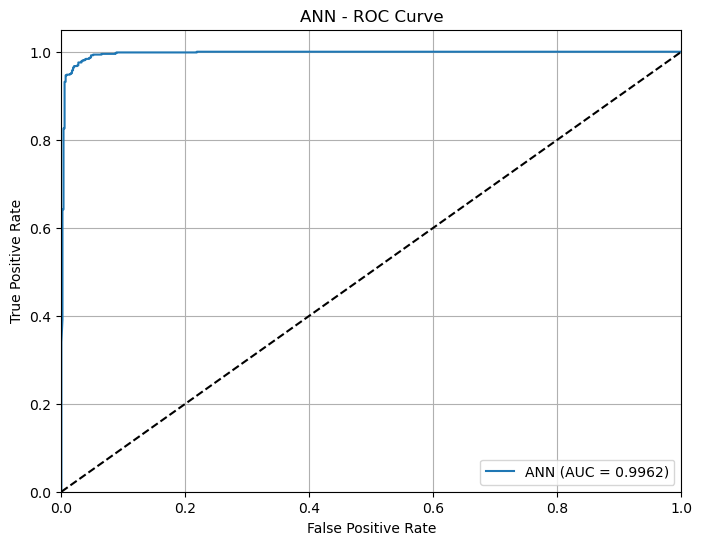

ANN Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [16]:
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)
ann_metrics = evaluate_model(y_test, y_pred_ann, 'ANN', ann_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


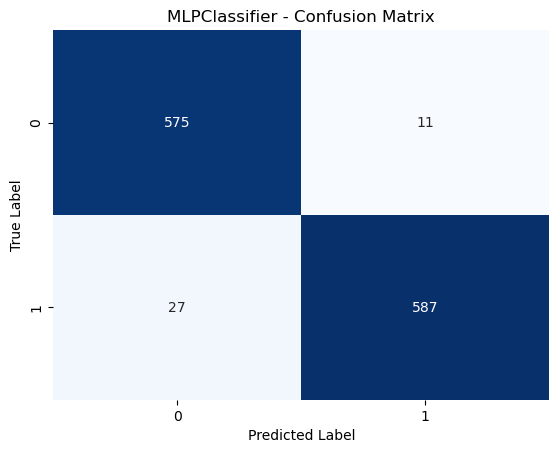

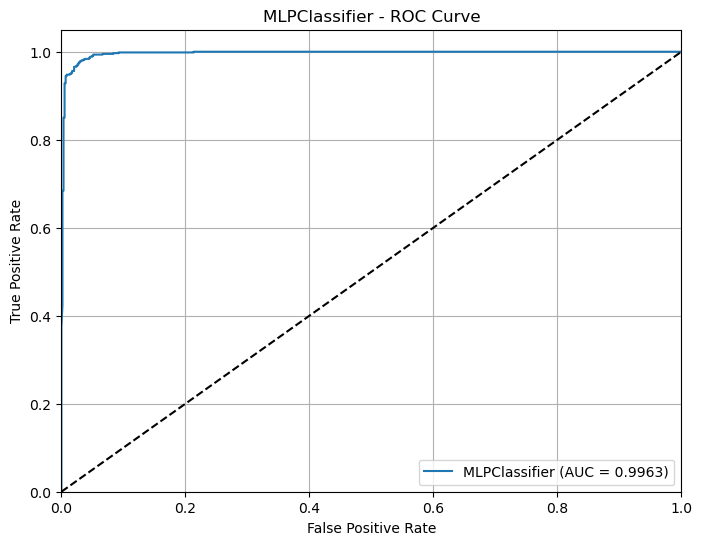

MLPClassifier Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [ ]:
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, 'MLPClassifier', mlp_model, X_test)

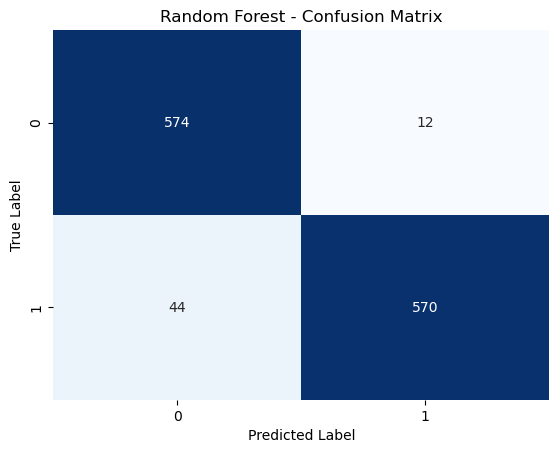

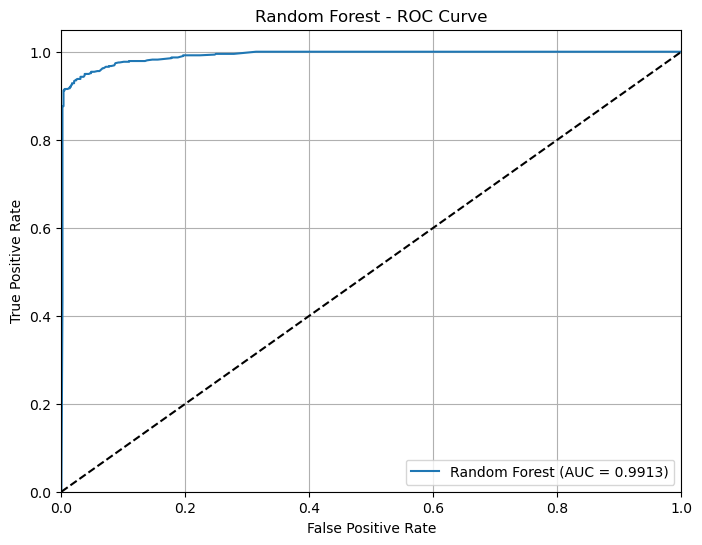

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95



In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest', model, X_test)

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.956667   0.973064      0.941368           0.972696   
1          Naive Bayes  0.932500   0.970018      0.895765           0.970990   
2        Decision Tree  0.928333   0.932787      0.926710           0.930034   
3                  SVM  0.969167   0.980033      0.959283           0.979522   
4                  ANN  0.970000   0.983278      0.957655           0.982935   
5        MLPClassifier  0.968333   0.981605      0.956026           0.981229   
6        Random Forest  0.953333   0.979381      0.928339           0.979522   

   F1 Score  
0  0.956954  
1  0.931414  
2  0.929739  
3  0.969547  
4  0.970297  
5  0.968647  
6  0.953177  


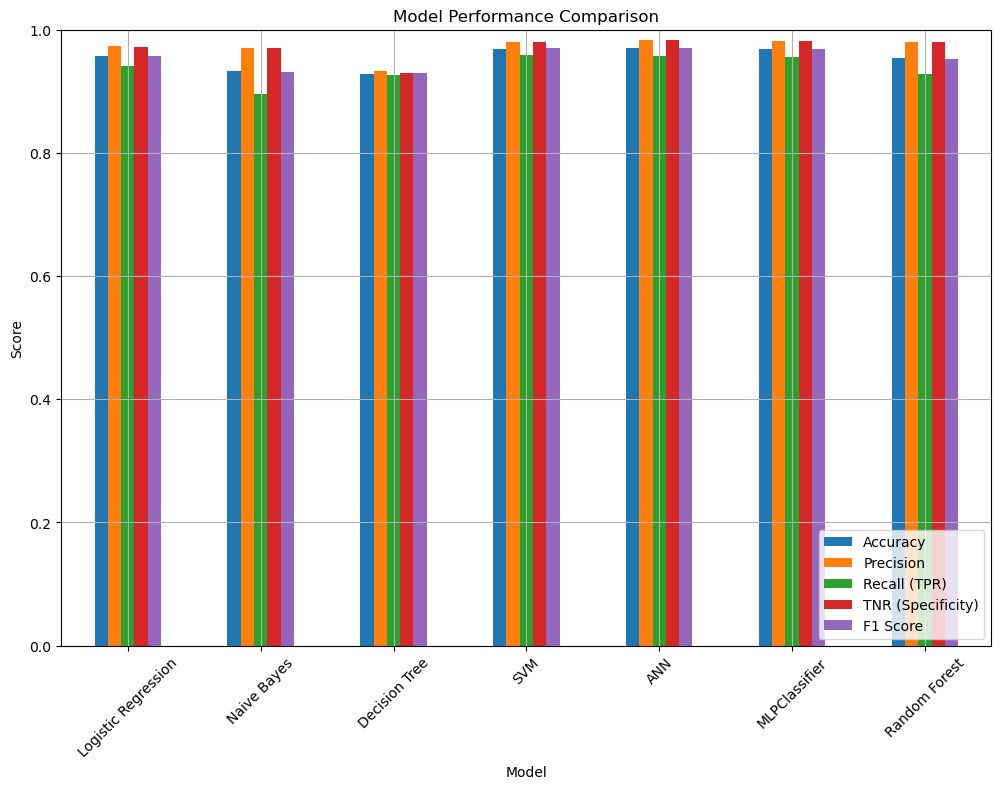

In [ ]:

results = pd.DataFrame([
    logistic_metrics,
    nb_metrics,
    dt_metrics,
    svm_metrics,
    ann_metrics,
    mlp_metrics,
    rf_metrics
])


print(results)


results.set_index('Model').plot(kind='bar', figsize=(12, 8), grid=True)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Öznitelik çıkarımı için fonksiyonlar
import re
from urllib.parse import urlparse

# Öznitelik çıkarımı
def extract_features(df):
    def url_length(url):
        return len(url)
    
    def num_subdomains(url):
        return urlparse(url).netloc.count('.')
    
    def is_ip(url):
        return 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', urlparse(url).netloc) else 0
    
    def num_special_chars(url):
        return len(re.findall(r'[^a-zA-Z0-9]', url))
    
    def num_parameters(url):
        return len(urlparse(url).query.split('&')) if urlparse(url).query else 0
    
    def has_https(url):
        return 1 if urlparse(url).scheme == 'https' else 0

    def num_images(url):
        return len(re.findall(r'<img', url, re.IGNORECASE))
    
    def text_length(url):
        return len(url)
    
    def num_keywords(url):
        keywords = ['login', 'secure', 'account', 'update', 'signin', 'verify']
        return sum([1 for keyword in keywords if keyword in url.lower()])
    
    def has_ip(url):
        return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0
    
    df['url_length'] = df['domain'].apply(url_length)
    df['num_subdomains'] = df['domain'].apply(num_subdomains)
    df['is_ip'] = df['domain'].apply(is_ip)
    df['num_special_chars'] = df['domain'].apply(num_special_chars)
    df['num_parameters'] = df['domain'].apply(num_parameters)
    df['has_https'] = df['domain'].apply(has_https)
    df['num_images'] = df['domain'].apply(num_images)
    df['text_length'] = df['domain'].apply(text_length)
    df['num_keywords'] = df['domain'].apply(num_keywords)
    df['has_ip'] = df['domain'].apply(has_ip)

    return df

# Öznitelik çıkarımı fonksiyonunu kullanma
balanced_data = extract_features(balanced_data)

# Sonuçların ilk birkaç satırını göster
print(balanced_data.head())

                      domain  label  url_length  num_subdomains  is_ip  \
0         fi4tfn.webwave.dev      1          18               0      0   
1  suggestqueries.google.com      0          25               0      0   
2                    ipfs.io      1           7               0      0   
3    ipfs.eth.aragon.network      1          23               0      0   
4   3-courier.push.apple.com      0          24               0      0   

   num_special_chars  num_parameters  has_https  num_images  text_length  \
0                  2               0          0           0           18   
1                  2               0          0           0           25   
2                  1               0          0           0            7   
3                  3               0          0           0           23   
4                  4               0          0           0           24   

   num_keywords  has_ip  
0             0       0  
1             0       0  
2             0     

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Öznitelik çıkarımı için fonksiyonlar
import re
from urllib.parse import urlparse


# Öznitelik çıkarımı fonksiyonları
def extract_features(df):
    def url_length(url):
        return len(url)
    
    def num_subdomains(url):
        return urlparse(url).netloc.count('.')
    
    def is_ip(url):
        return 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', urlparse(url).netloc) else 0
    
    def num_special_chars(url):
        return len(re.findall(r'[^a-zA-Z0-9]', url))
    
    def num_parameters(url):
        return len(urlparse(url).query.split('&')) if urlparse(url).query else 0
    
    def has_https(url):
        return 1 if urlparse(url).scheme == 'https' else 0

    def num_images(url):
        return len(re.findall(r'<img', url, re.IGNORECASE))
    
    def text_length(url):
        return len(url)
    
    def num_keywords(url):
        keywords = ['login', 'secure', 'account', 'update', 'signin', 'verify']
        return sum([1 for keyword in keywords if keyword in url.lower()])
    
    def has_ip(url):
        return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0
    
    df['url_length'] = df['domain'].apply(url_length)
    df['num_subdomains'] = df['domain'].apply(num_subdomains)
    df['is_ip'] = df['domain'].apply(is_ip)
    df['num_special_chars'] = df['domain'].apply(num_special_chars)
    df['num_parameters'] = df['domain'].apply(num_parameters)
    df['has_https'] = df['domain'].apply(has_https)
    df['num_images'] = df['domain'].apply(num_images)
    df['text_length'] = df['domain'].apply(text_length)
    df['num_keywords'] = df['domain'].apply(num_keywords)
    df['has_ip'] = df['domain'].apply(has_ip)

    return df

# Öznitelik çıkarımı fonksiyonunu kullanma
balanced_data = extract_features(balanced_data)

# TF-IDF Vektörizasyonu
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X_tfidf = vectorizer.fit_transform(balanced_data['domain'])

# Ekstrakte edilen diğer özellikler
additional_features = balanced_data[['url_length', 'num_subdomains', 'is_ip', 'num_special_chars',
                                     'num_parameters', 'has_https', 'num_images', 'text_length',
                                     'num_keywords', 'has_ip']]

# Tüm özellikleri birleştirme (TF-IDF + Ekstrakte edilen özellikler)
from scipy.sparse import hstack
X = hstack([X_tfidf, additional_features])

# Hedef değişken
y = balanced_data['label']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:

# Model eğitimi için değerlendirme fonksiyonu
def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    # Performans Metriklerini Yazdır
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

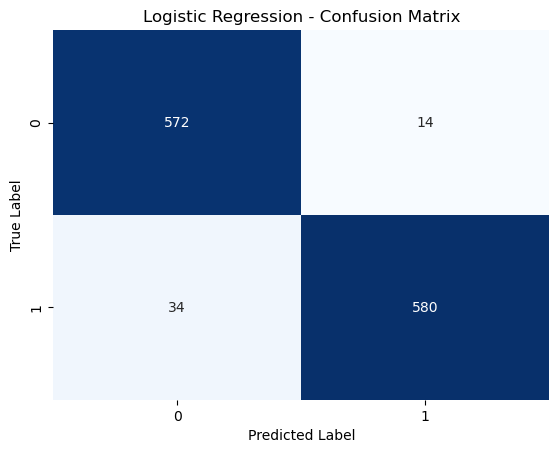

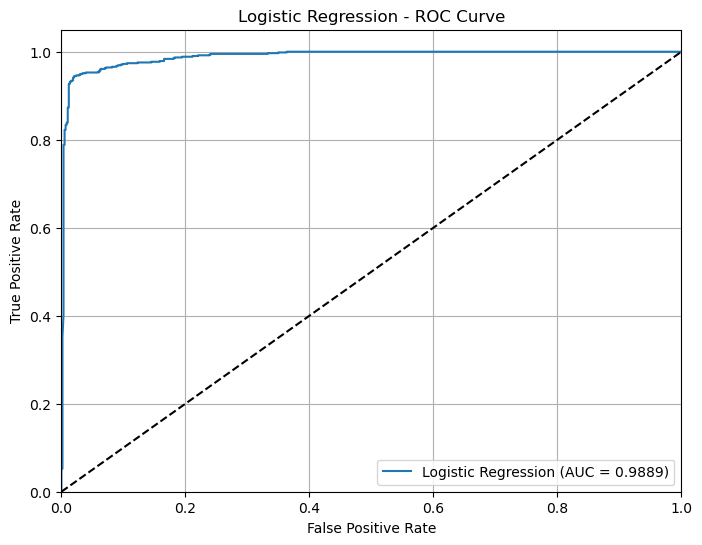

Logistic Regression Performance:
Accuracy: 0.96
Precision: 0.98
Recall (TPR): 0.94
TNR (Specificity): 0.98
F1 Score: 0.96



In [37]:
# Kod Hücresi 3: Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, 'Logistic Regression', logistic_model, X_test)


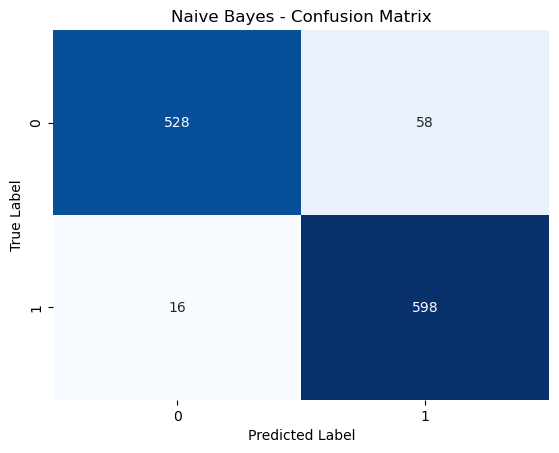

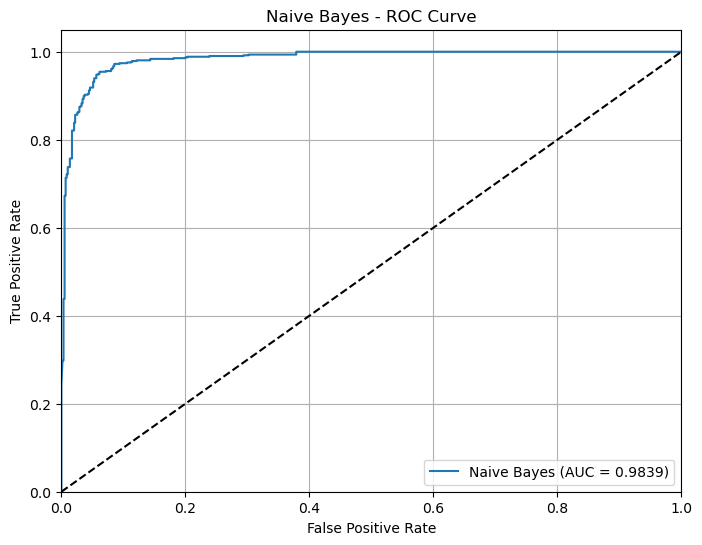

Naive Bayes Performance:
Accuracy: 0.94
Precision: 0.91
Recall (TPR): 0.97
TNR (Specificity): 0.90
F1 Score: 0.94



In [38]:
# Kod Hücresi 4: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_metrics = evaluate_model(y_test, y_pred_nb, 'Naive Bayes', nb_model, X_test)

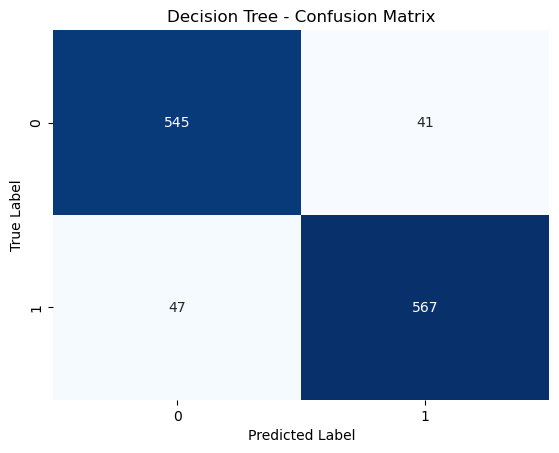

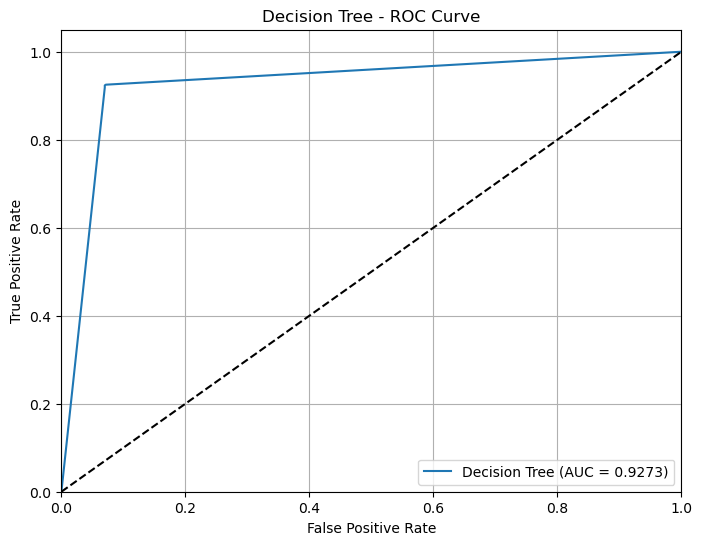

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.92
TNR (Specificity): 0.93
F1 Score: 0.93



In [39]:
# Kod Hücresi 5: Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree', dt_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


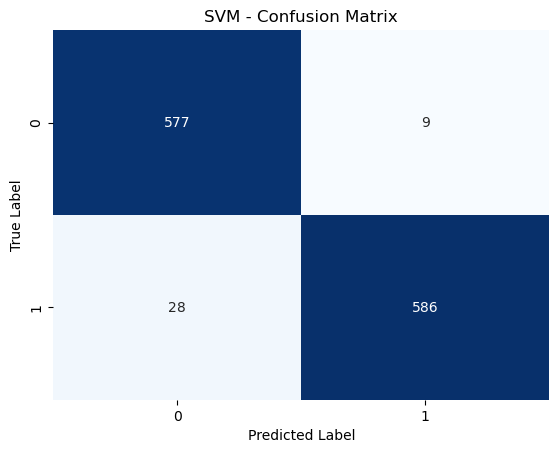

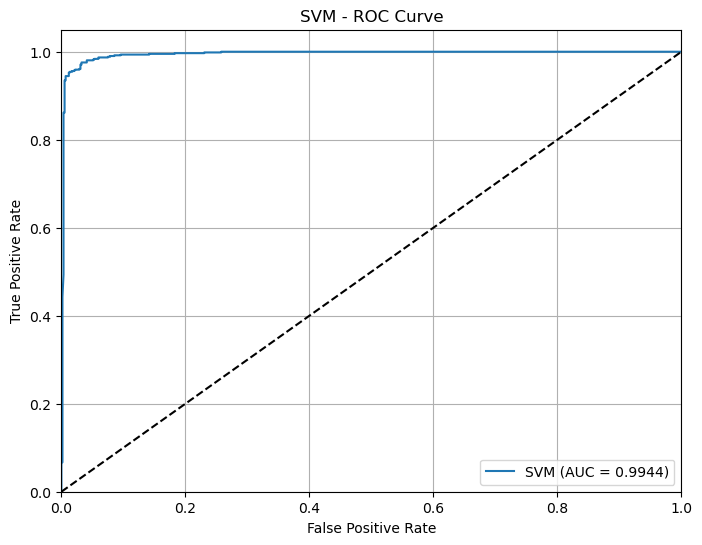

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.95
TNR (Specificity): 0.98
F1 Score: 0.97



In [40]:
# Kod Hücresi 6: Support Vector Machine (SVM)
svm_model = LinearSVC(random_state=42, max_iter=1000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM', svm_model, X_test)


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


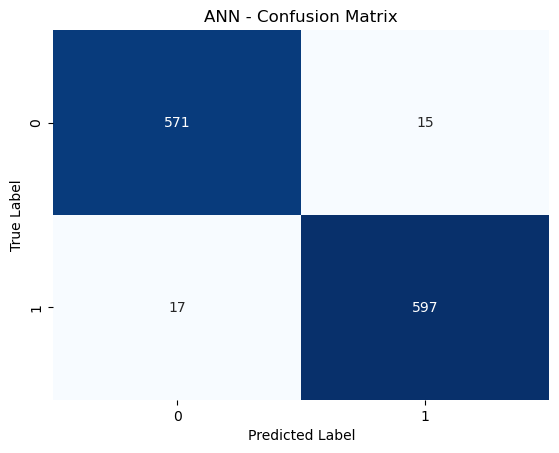

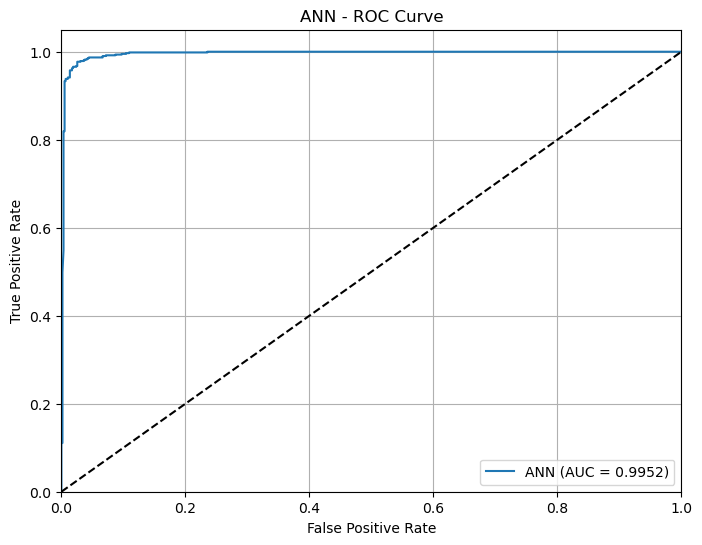

ANN Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.97
TNR (Specificity): 0.97
F1 Score: 0.97



In [41]:
# Kod Hücresi 7: Artificial Neural Network (ANN)
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)
ann_metrics = evaluate_model(y_test, y_pred_ann, 'ANN', ann_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


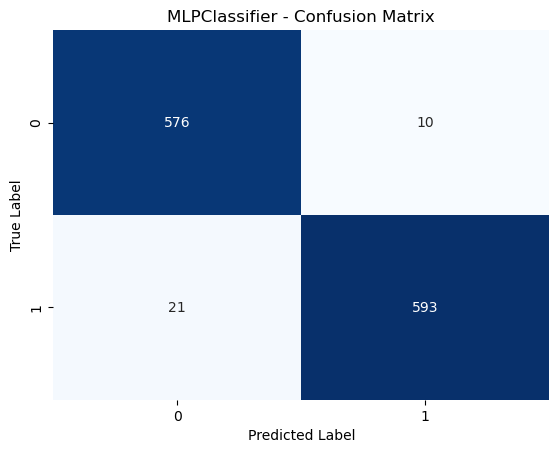

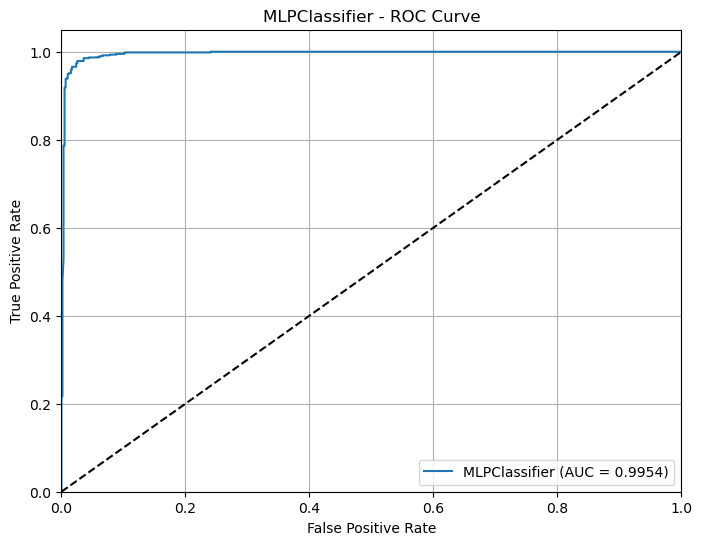

MLPClassifier Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.97
TNR (Specificity): 0.98
F1 Score: 0.97



In [42]:
# Kod Hücresi 8: MLPClassifier (Ek olarak)
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, 'MLPClassifier', mlp_model, X_test)

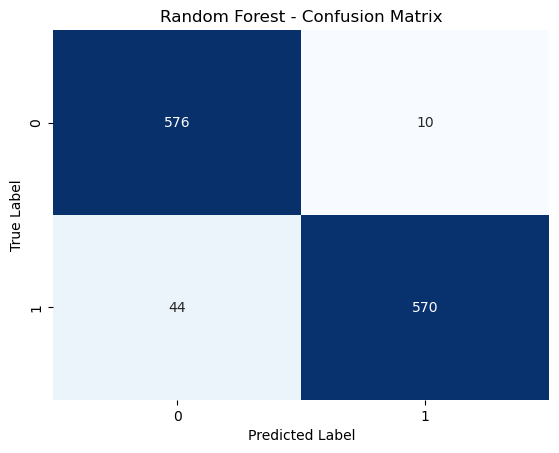

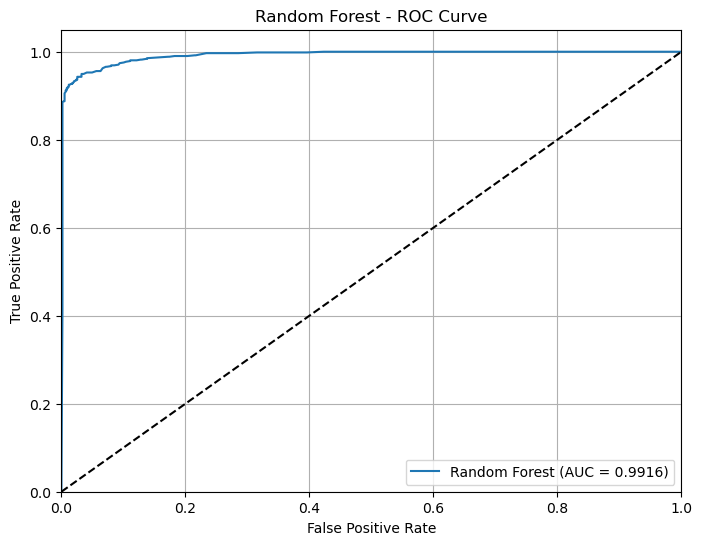

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95



In [43]:
# Kod Hücresi 9: Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest', rf_model, X_test)

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.960000   0.976431      0.944625           0.976109   
1          Naive Bayes  0.938333   0.911585      0.973941           0.901024   
2        Decision Tree  0.926667   0.932566      0.923453           0.930034   
3                  SVM  0.969167   0.984874      0.954397           0.984642   
4                  ANN  0.973333   0.975490      0.972313           0.974403   
5        MLPClassifier  0.974167   0.983416      0.965798           0.982935   
6        Random Forest  0.955000   0.982759      0.928339           0.982935   

   F1 Score  
0  0.960265  
1  0.941732  
2  0.927987  
3  0.969396  
4  0.973899  
5  0.974528  
6  0.954774  


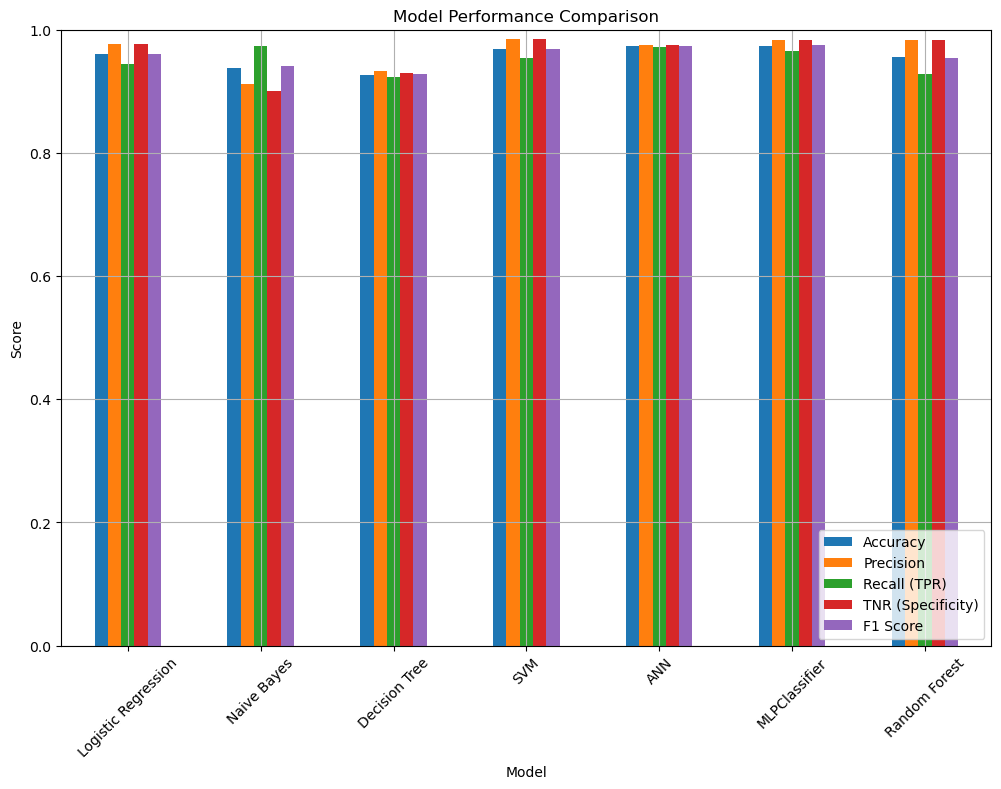

In [44]:
# Kod Hücresi 10: Sonuçların Karşılaştırılması
results = pd.DataFrame([
    logistic_metrics,
    nb_metrics,
    dt_metrics,
    svm_metrics,
    ann_metrics,
    mlp_metrics,
    rf_metrics
])

print(results)

# Karşılaştırma Grafiği
results.set_index('Model').plot(kind='bar', figsize=(12, 8), grid=True)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [64]:
from sklearn.decomposition import TruncatedSVD
# TruncatedSVD (PCA Alternatifi) ile boyut azaltma
svd = TruncatedSVD(n_components=5, random_state=42)  # Örnek olarak 5 bileşene indirgemek için
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# Random Forest ile en önemli özellikleri seçme
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_svd, y_train)

RandomForestClassifier(random_state=42)

In [66]:
import numpy as np
# Özellik önem derecelerini alalım
feature_importances = rf.feature_importances_

# En önemli 5 özelliği seç
indices = np.argsort(feature_importances)[::-1][:5]
X_train_rf = X_train_svd[:, indices]
X_test_rf = X_test_svd[:, indices]

In [67]:
# Model değerlendirme fonksiyonu
def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        elif hasattr(model_obj, "decision_function"):
            y_prob = model_obj.decision_function(X_test)
        else:
            y_prob = None

        if y_prob is not None:
            fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr_curve)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()

    # Performans Metriklerini Yazdır
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }





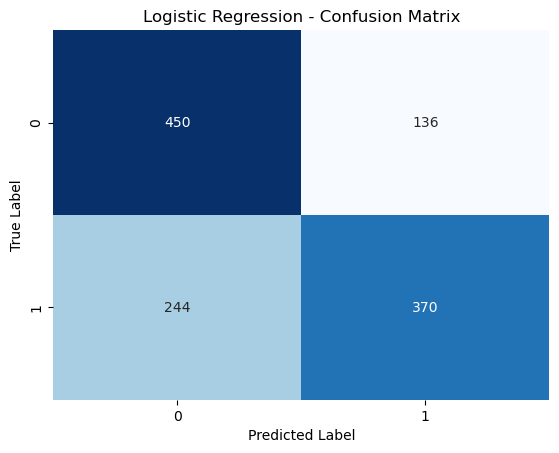

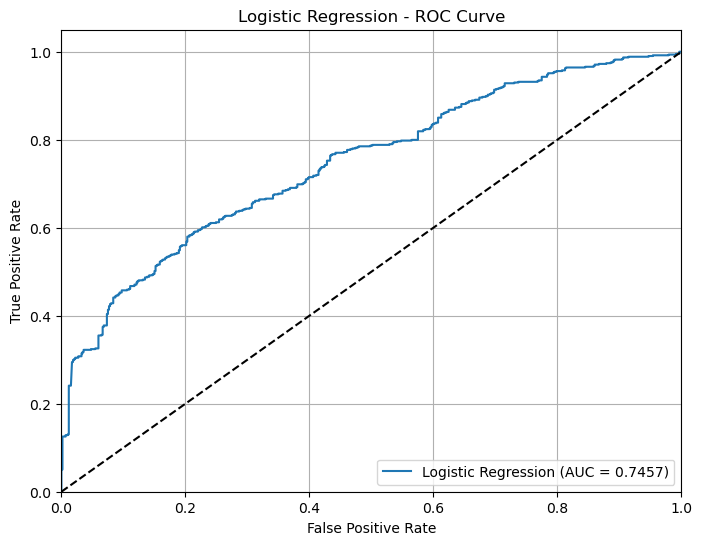

Logistic Regression Performance:
Accuracy: 0.68
Precision: 0.73
Recall (TPR): 0.60
TNR (Specificity): 0.77
F1 Score: 0.66



In [68]:
# Kod Hücresi 3: Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_rf, y_train)
y_pred_logistic = logistic_model.predict(X_test_rf)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, 'Logistic Regression', logistic_model, X_test_rf)


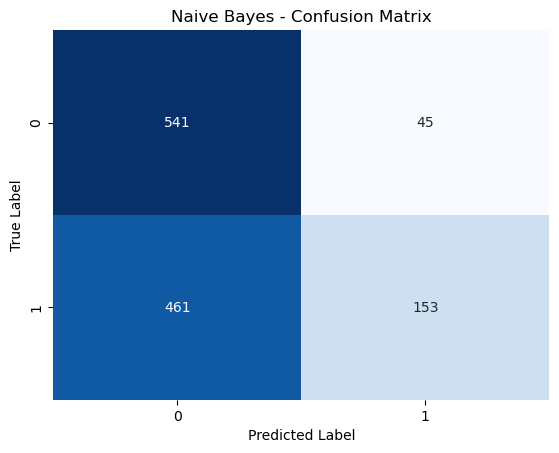

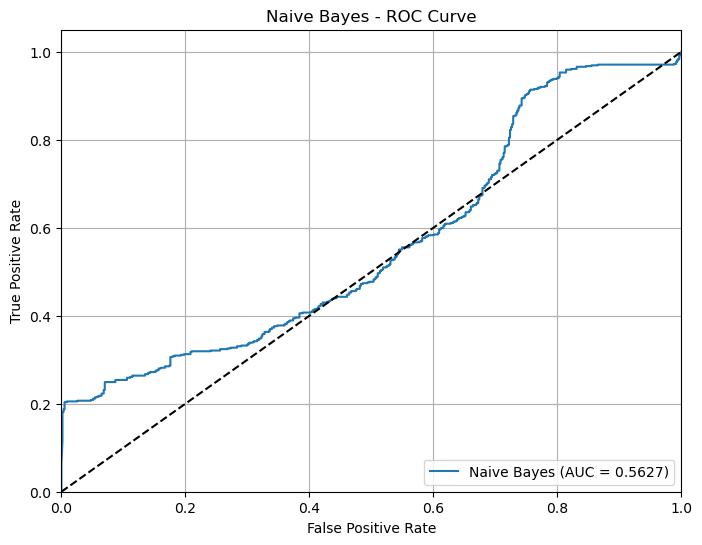

Naive Bayes Performance:
Accuracy: 0.58
Precision: 0.77
Recall (TPR): 0.25
TNR (Specificity): 0.92
F1 Score: 0.38



In [69]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaling ile verilerin pozitif yapılması
scaler = MinMaxScaler()
X_train_rf_scaled = scaler.fit_transform(X_train_rf)
X_test_rf_scaled = scaler.transform(X_test_rf)

# Kod Hücresi 4: Naive Bayes (MultinomialNB)
nb_model = MultinomialNB()
nb_model.fit(X_train_rf_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_rf_scaled)
nb_metrics = evaluate_model(y_test, y_pred_nb, 'Naive Bayes', nb_model, X_test_rf_scaled)

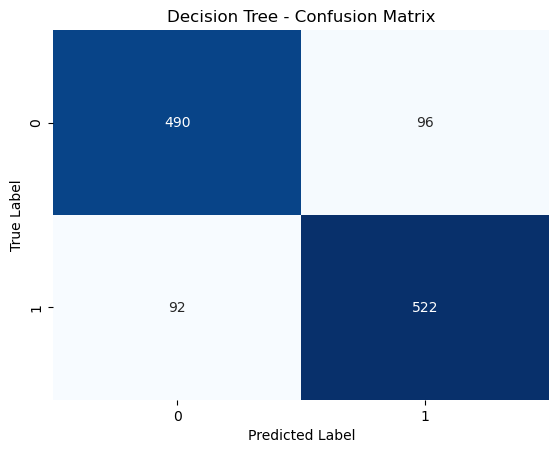

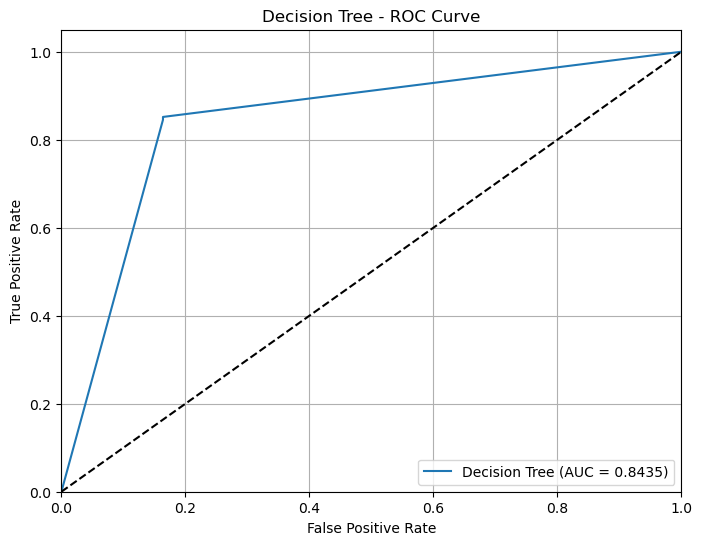

Decision Tree Performance:
Accuracy: 0.84
Precision: 0.84
Recall (TPR): 0.85
TNR (Specificity): 0.84
F1 Score: 0.85



In [70]:

# Kod Hücresi 5: Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_rf, y_train)
y_pred_dt = dt_model.predict(X_test_rf)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree', dt_model, X_test_rf)


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


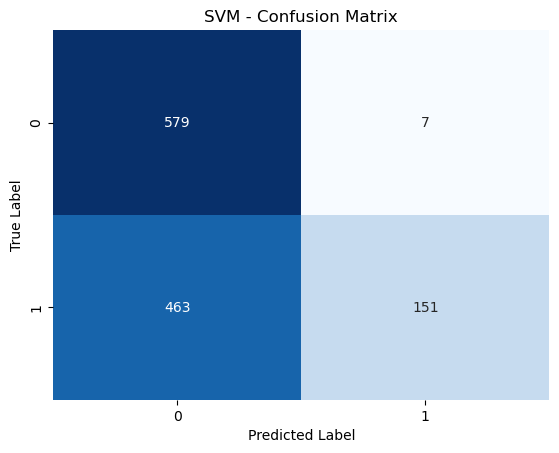

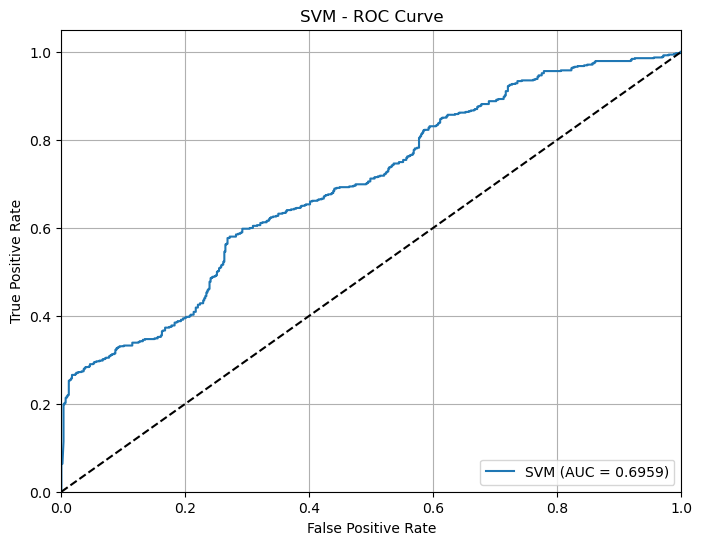

SVM Performance:
Accuracy: 0.61
Precision: 0.96
Recall (TPR): 0.25
TNR (Specificity): 0.99
F1 Score: 0.39



In [71]:

# Kod Hücresi 6: Support Vector Machine (SVM)
svm_model = LinearSVC(random_state=42, max_iter=1000)
svm_model.fit(X_train_rf, y_train)
y_pred_svm = svm_model.predict(X_test_rf)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM', svm_model, X_test_rf)


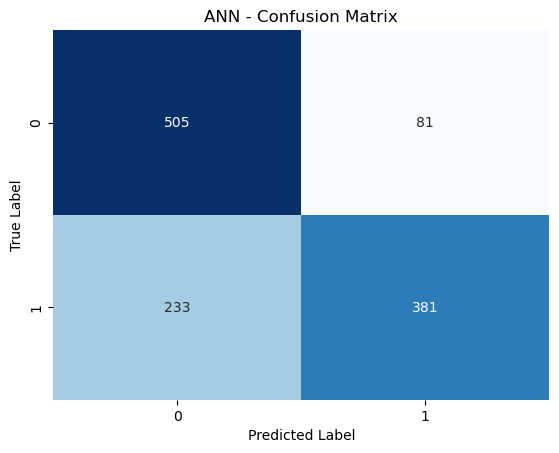

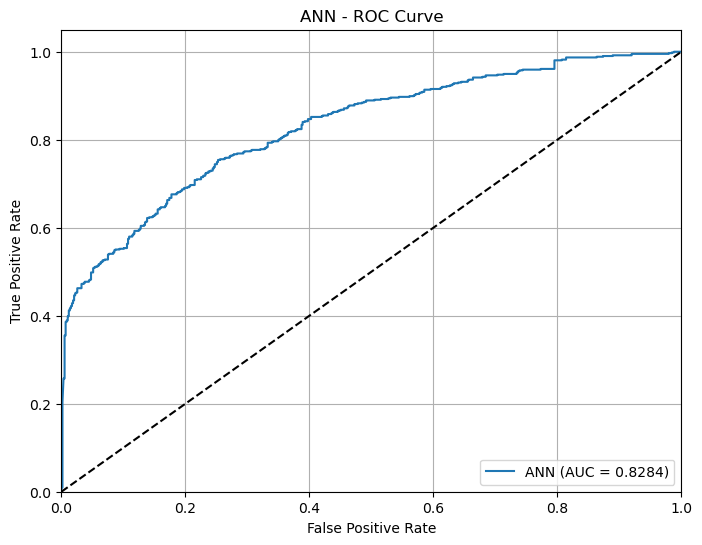

ANN Performance:
Accuracy: 0.74
Precision: 0.82
Recall (TPR): 0.62
TNR (Specificity): 0.86
F1 Score: 0.71



In [72]:

# Kod Hücresi 7: Artificial Neural Network (ANN)
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train_rf, y_train)
y_pred_ann = ann_model.predict(X_test_rf)
ann_metrics = evaluate_model(y_test, y_pred_ann, 'ANN', ann_model, X_test_rf)


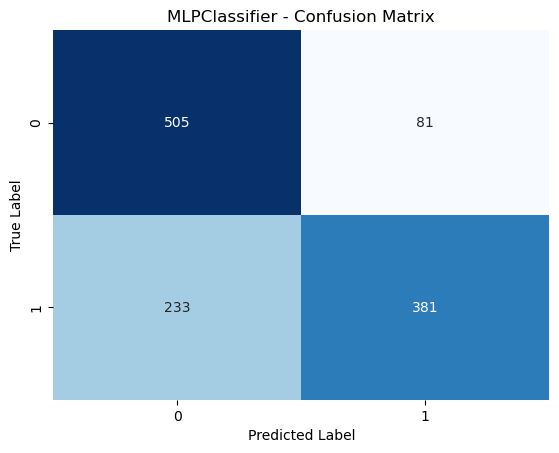

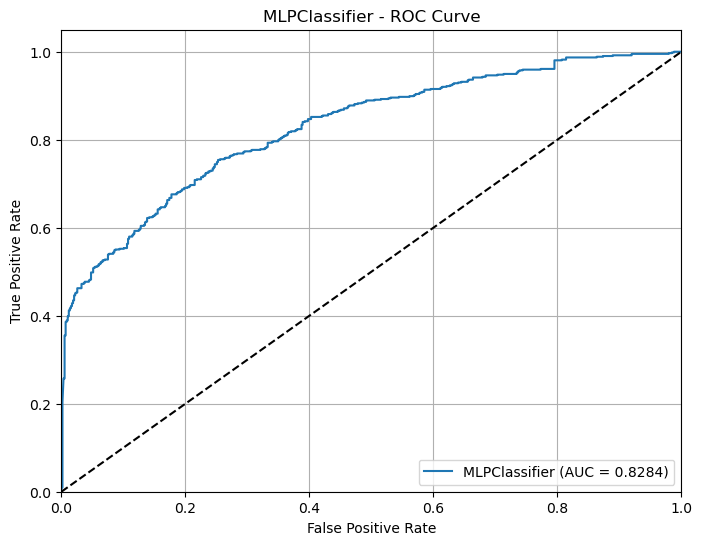

MLPClassifier Performance:
Accuracy: 0.74
Precision: 0.82
Recall (TPR): 0.62
TNR (Specificity): 0.86
F1 Score: 0.71



In [73]:
# Kod Hücresi 8: MLPClassifier (Ek olarak)
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train_rf, y_train)
y_pred_mlp = mlp_model.predict(X_test_rf)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, 'MLPClassifier', mlp_model, X_test_rf)



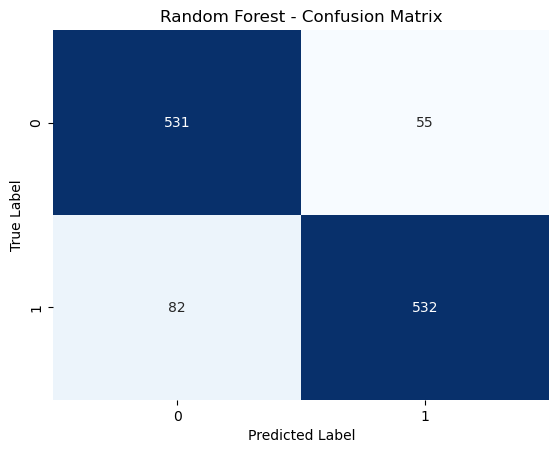

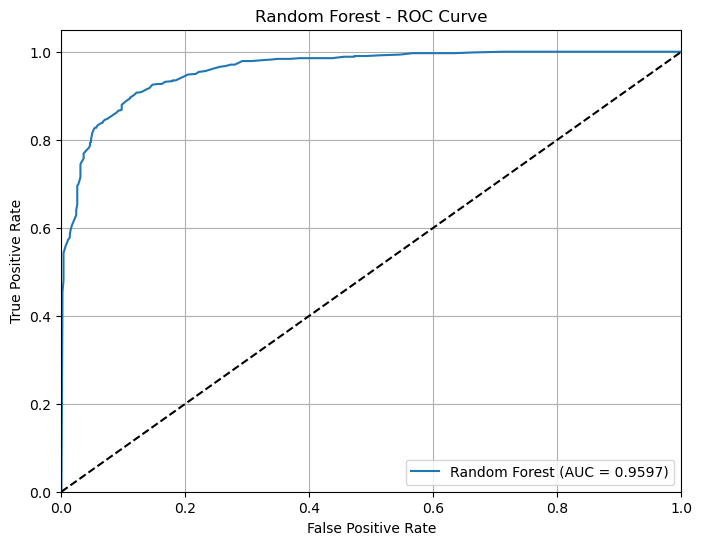

Random Forest Performance:
Accuracy: 0.89
Precision: 0.91
Recall (TPR): 0.87
TNR (Specificity): 0.91
F1 Score: 0.89



In [74]:
# Kod Hücresi 9: Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest', rf_model, X_test_rf)

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.683333   0.731225      0.602606           0.767918   
1          Naive Bayes  0.578333   0.772727      0.249186           0.923208   
2        Decision Tree  0.843333   0.844660      0.850163           0.836177   
3                  SVM  0.608333   0.955696      0.245928           0.988055   
4                  ANN  0.738333   0.824675      0.620521           0.861775   
5        MLPClassifier  0.738333   0.824675      0.620521           0.861775   
6        Random Forest  0.885833   0.906303      0.866450           0.906143   

   F1 Score  
0  0.660714  
1  0.376847  
2  0.847403  
3  0.391192  
4  0.708178  
5  0.708178  
6  0.885928  


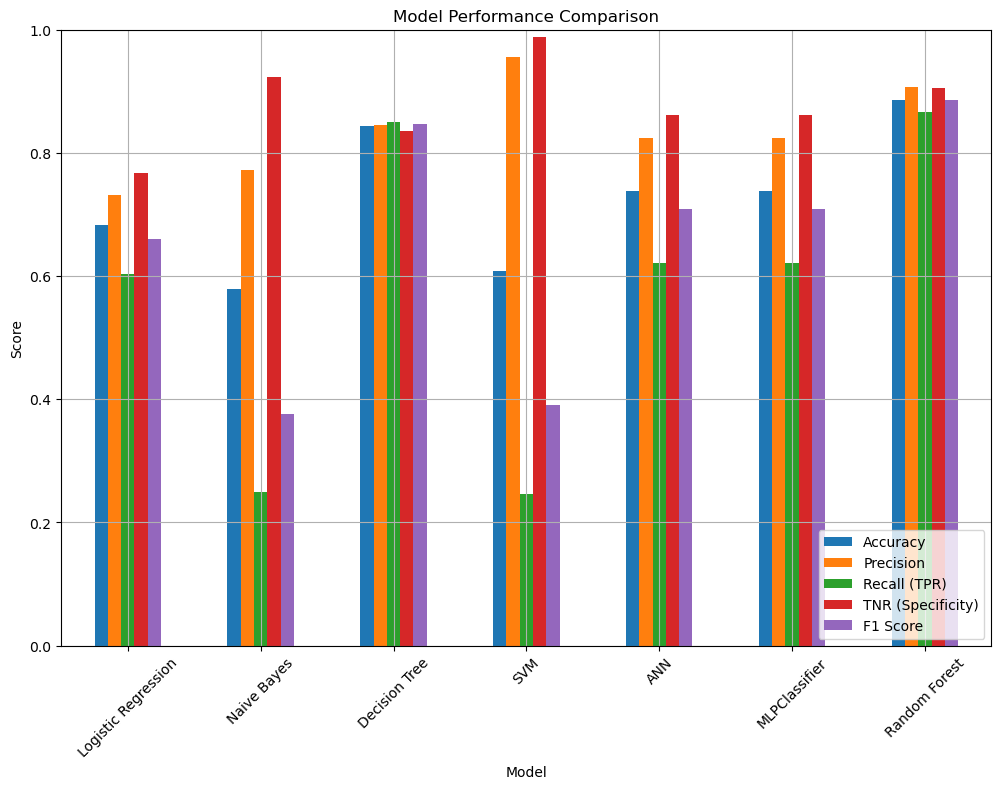

In [75]:
# Kod Hücresi 10: Sonuçların Karşılaştırılması
results = pd.DataFrame([
    logistic_metrics,
    nb_metrics,
    dt_metrics,
    svm_metrics,
    ann_metrics,
    mlp_metrics,
    rf_metrics
])

print(results)

# Karşılaştırma Grafiği
results.set_index('Model').plot(kind='bar', figsize=(12, 8), grid=True)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

Normalizasyon , Standartizasyon , Ölçeklendirme 

Normalization Results:


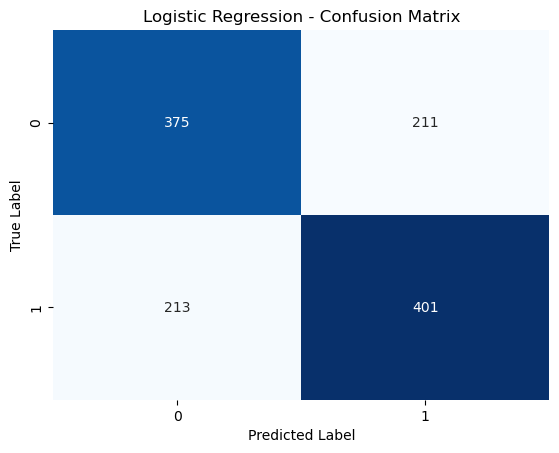

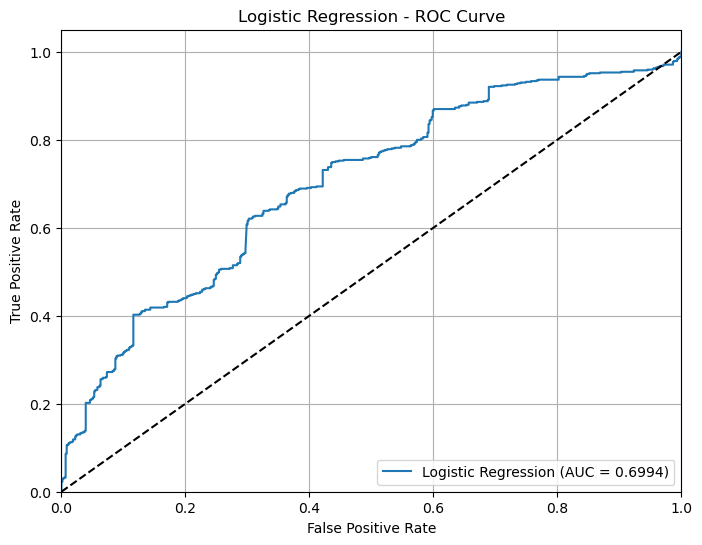

Logistic Regression Performance:
Accuracy: 0.65
Precision: 0.66
Recall (TPR): 0.65
TNR (Specificity): 0.64
F1 Score: 0.65



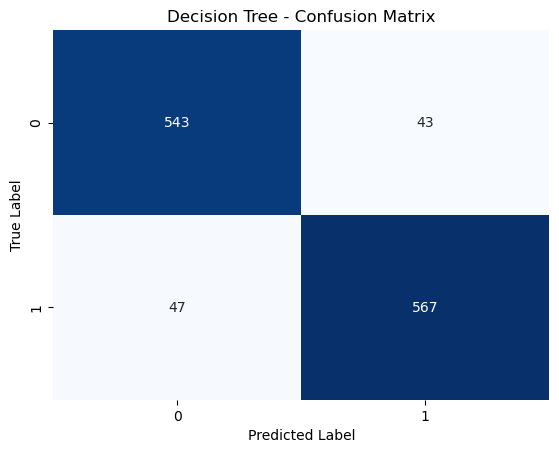

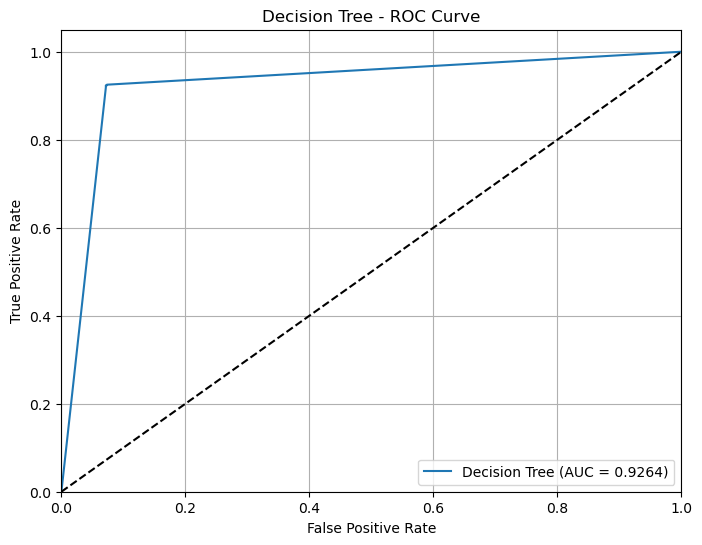

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.92
TNR (Specificity): 0.93
F1 Score: 0.93



c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


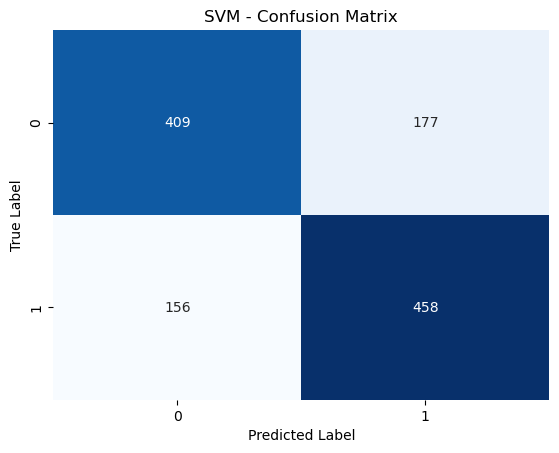

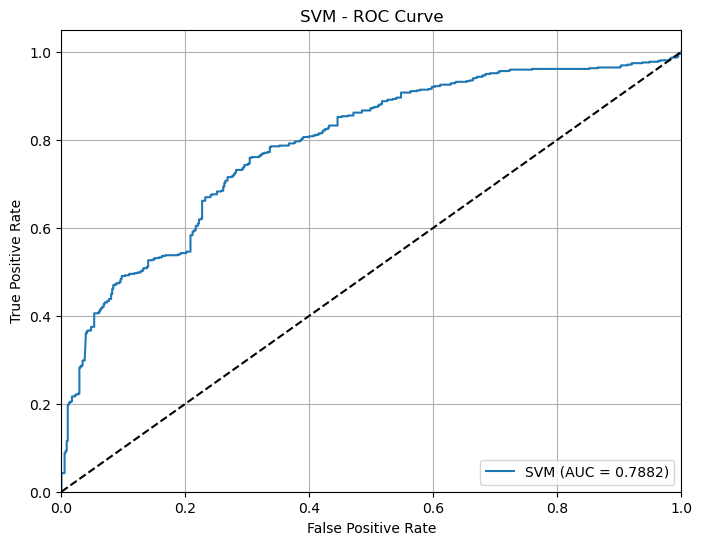

SVM Performance:
Accuracy: 0.72
Precision: 0.72
Recall (TPR): 0.75
TNR (Specificity): 0.70
F1 Score: 0.73



c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


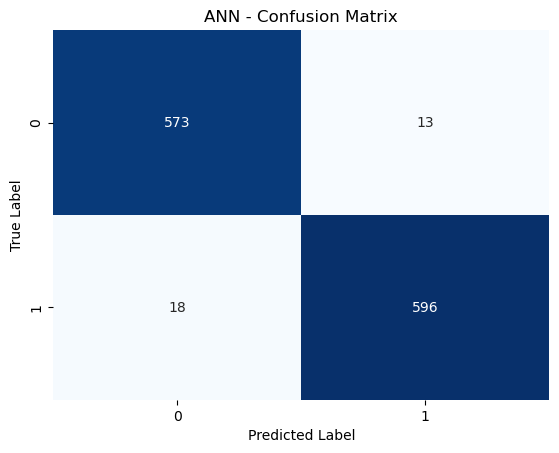

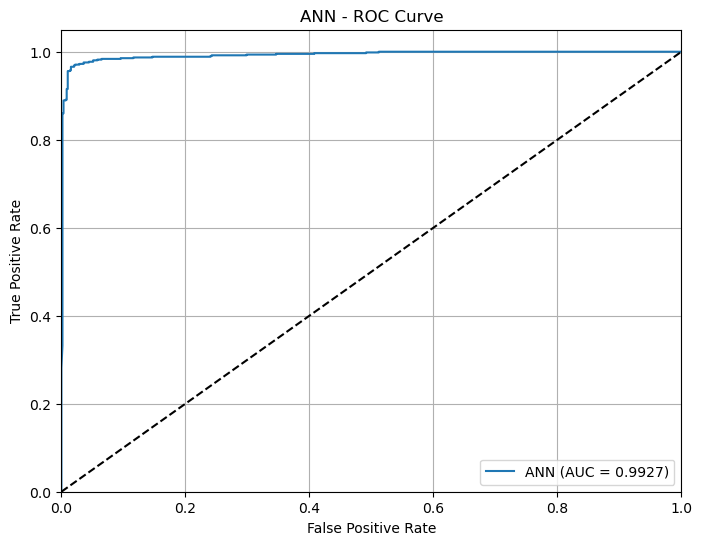

ANN Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.97
TNR (Specificity): 0.98
F1 Score: 0.97



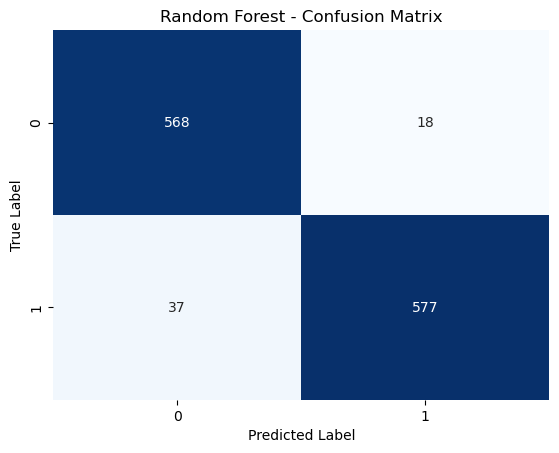

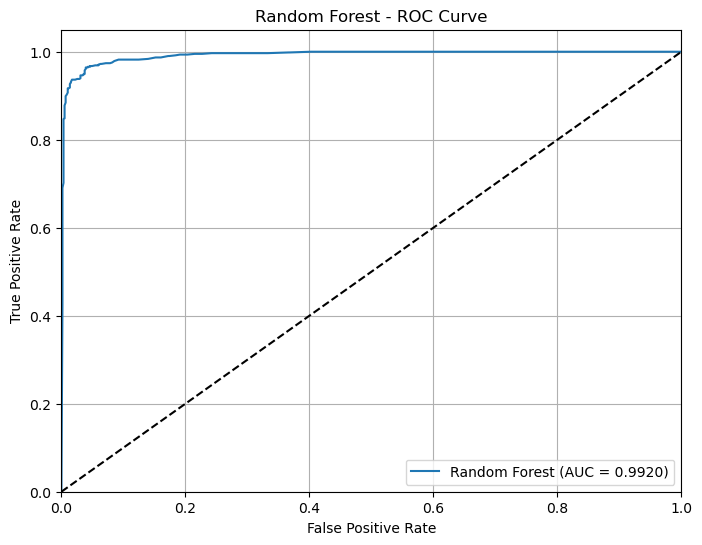

Random Forest Performance:
Accuracy: 0.95
Precision: 0.97
Recall (TPR): 0.94
TNR (Specificity): 0.97
F1 Score: 0.95



c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


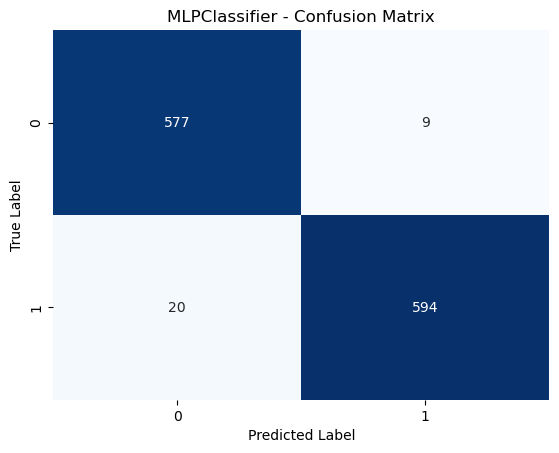

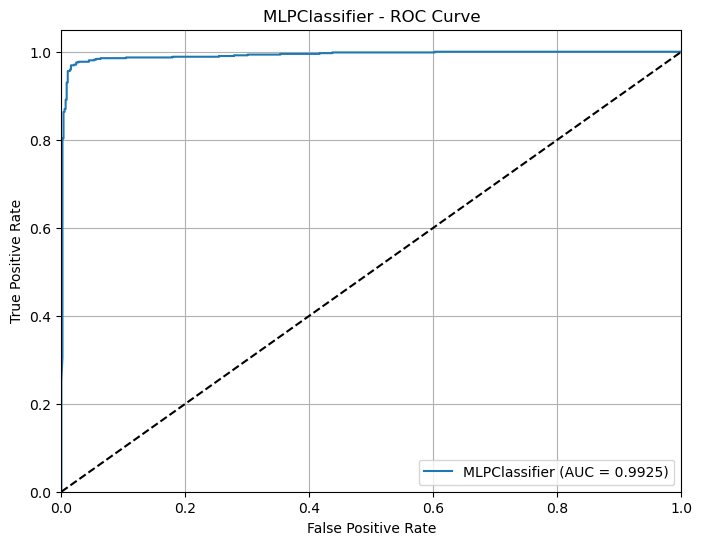

MLPClassifier Performance:
Accuracy: 0.98
Precision: 0.99
Recall (TPR): 0.97
TNR (Specificity): 0.98
F1 Score: 0.98



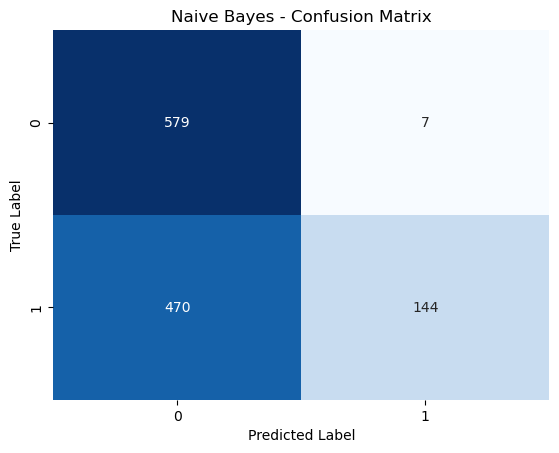

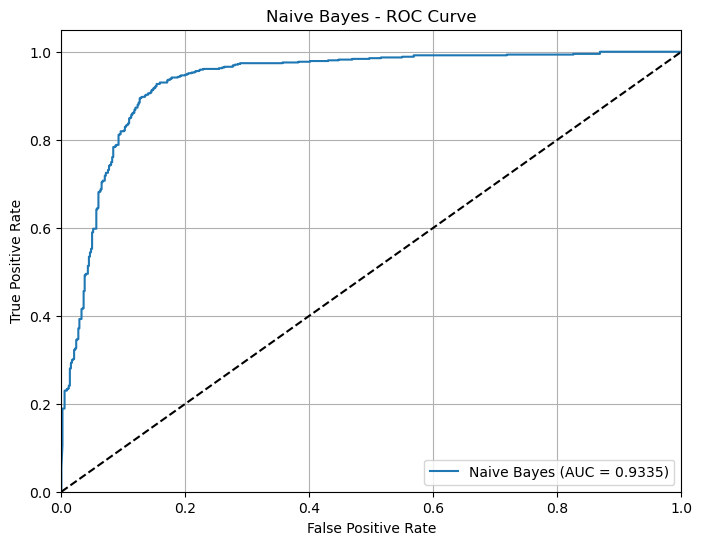

Naive Bayes Performance:
Accuracy: 0.60
Precision: 0.95
Recall (TPR): 0.23
TNR (Specificity): 0.99
F1 Score: 0.38

Standardization Results:


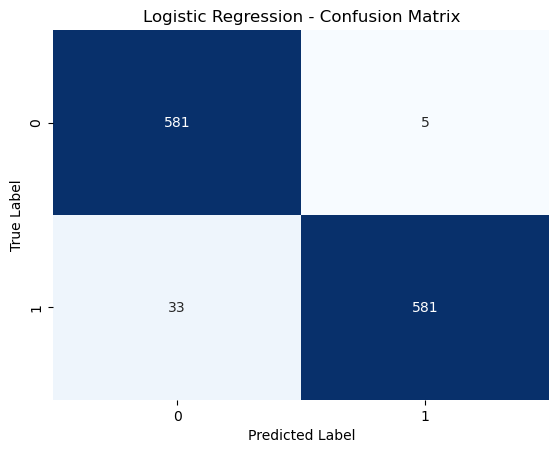

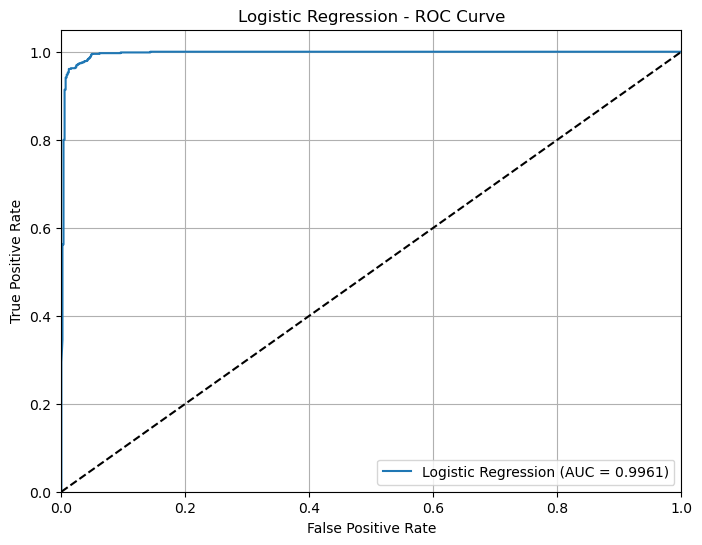

Logistic Regression Performance:
Accuracy: 0.97
Precision: 0.99
Recall (TPR): 0.95
TNR (Specificity): 0.99
F1 Score: 0.97



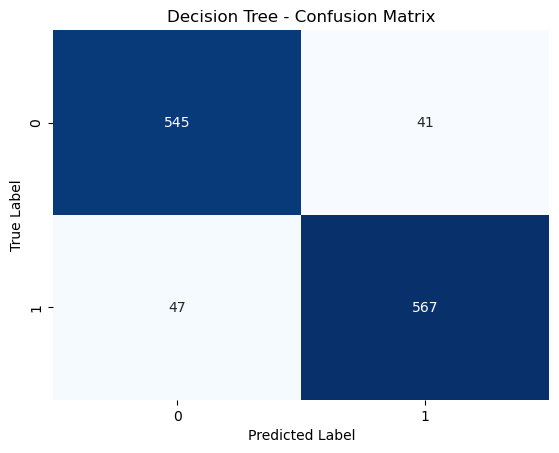

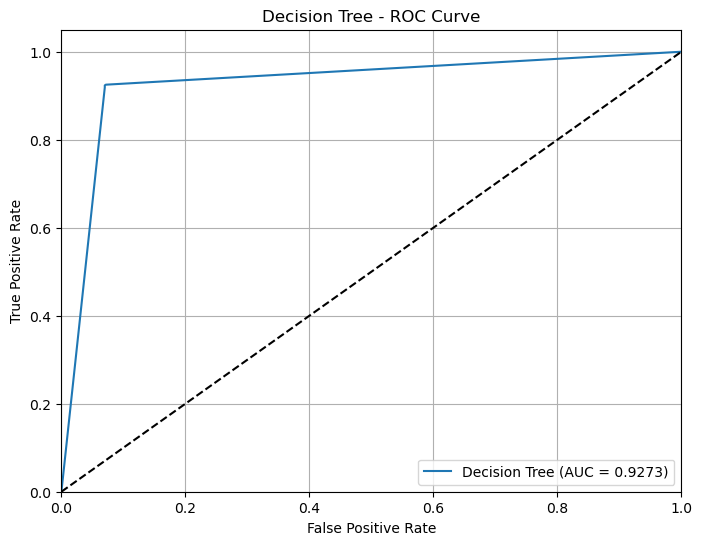

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.92
TNR (Specificity): 0.93
F1 Score: 0.93



c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


KeyboardInterrupt: 

In [14]:
from sklearn.preprocessing import Normalizer

# Önceki importlar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Yeni importlar
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from scipy.sparse import hstack

# Öznitelik çıkarımı fonksiyonu
def extract_features(df):
    from urllib.parse import urlparse
    import re

    def url_length(url):
        return len(url)
    
    def num_subdomains(url):
        return urlparse(url).netloc.count('.')
    
    def is_ip(url):
        return 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', urlparse(url).netloc) else 0
    
    def num_special_chars(url):
        return len(re.findall(r'[^a-zA-Z0-9]', url))
    
    def num_parameters(url):
        return len(urlparse(url).query.split('&')) if urlparse(url).query else 0
    
    def has_https(url):
        return 1 if urlparse(url).scheme == 'https' else 0

    def num_images(url):
        return len(re.findall(r'<img', url, re.IGNORECASE))
    
    def text_length(url):
        return len(url)
    
    def num_keywords(url):
        keywords = ['login', 'secure', 'account', 'update', 'signin', 'verify']
        return sum([1 for keyword in keywords if keyword in url.lower()])
    
    def has_ip(url):
        return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0
    
    df['url_length'] = df['domain'].apply(url_length)
    df['num_subdomains'] = df['domain'].apply(num_subdomains)
    df['is_ip'] = df['domain'].apply(is_ip)
    df['num_special_chars'] = df['domain'].apply(num_special_chars)
    df['num_parameters'] = df['domain'].apply(num_parameters)
    df['has_https'] = df['domain'].apply(has_https)
    df['num_images'] = df['domain'].apply(num_images)
    df['text_length'] = df['domain'].apply(text_length)
    df['num_keywords'] = df['domain'].apply(num_keywords)
    df['has_ip'] = df['domain'].apply(has_ip)

    return df

# Öznitelik çıkarımı fonksiyonunu kullanma
balanced_data = extract_features(balanced_data)

# TF-IDF Vektörizasyonu
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X_tfidf = vectorizer.fit_transform(balanced_data['domain'])

# Ekstrakte edilen diğer özellikler
additional_features = balanced_data[['url_length', 'num_subdomains', 'is_ip', 'num_special_chars',
                                     'num_parameters', 'has_https', 'num_images', 'text_length',
                                     'num_keywords', 'has_ip']]

# Tüm özellikleri birleştirme (TF-IDF + Ekstrakte edilen özellikler)
X = hstack([X_tfidf, additional_features])

# Hedef değişken
y = balanced_data['label']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model eğitimi için değerlendirme fonksiyonu
def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    # Performans Metriklerini Yazdır
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

# Model eğitimi fonksiyonu
def train_and_evaluate_models(X_train, X_test, y_train, y_test, include_nb=True):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': LinearSVC(random_state=42, max_iter=1000),
        'ANN': MLPClassifier(random_state=42, max_iter=300),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'MLPClassifier': MLPClassifier(random_state=42, max_iter=300)
    }

    if include_nb:
        models['Naive Bayes'] = MultinomialNB()

    results = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = evaluate_model(y_test, y_pred, model_name, model, X_test)
        results.append(metrics)

    return pd.DataFrame(results)

# Normalizasyon, standardizasyon ve ölçekleme işlemlerini gerçekleştiren fonksiyonlar
def normalize_features(X_train, X_test):
    normalizer = Normalizer()
    X_train_normalized = normalizer.fit_transform(X_train.toarray())
    X_test_normalized = normalizer.transform(X_test.toarray())
    return X_train_normalized, X_test_normalized

def standardize_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train.toarray())
    X_test_standardized = scaler.transform(X_test.toarray())
    return X_train_standardized, X_test_standardized

def minmax_scale_features(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.toarray())
    X_test_scaled = scaler.transform(X_test.toarray())
    return X_train_scaled, X_test_scaled

# Normalizasyon ile model eğitimi ve değerlendirme
print("Normalization Results:")
X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)
normalization_results = train_and_evaluate_models(X_train_normalized, X_test_normalized, y_train, y_test)

# Standardizasyon ile model eğitimi ve değerlendirme (MultinomialNB hariç)
print("Standardization Results:")
X_train_standardized, X_test_standardized = standardize_features(X_train, X_test)
standardization_results = train_and_evaluate_models(X_train_standardized, X_test_standardized, y_train, y_test, include_nb=False)

# Min-Max Ölçekleme ile model eğitimi ve değerlendirme
print("Min-Max Scaling Results:")
X_train_minmax, X_test_minmax = minmax_scale_features(X_train, X_test)
minmax_results = train_and_evaluate_models(X_train_minmax, X_test_minmax, y_train, y_test)

# Sonuçların karşılaştırılması
all_results = pd.concat([
    normalization_results.assign(Scaling='Normalization'),
    standardization_results.assign(Scaling='Standardization'),
    minmax_results.assign(Scaling='Min-Max Scaling')
])

# Sonuçları göster
print(all_results)

# Karşılaştırma Grafiği
plt.figure(figsize=(14, 8))
sns.barplot(data=all_results, x='Model', y='Accuracy', hue='Scaling')
plt.title('Model Performance Comparison by Scaling Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Scaling Method', loc='lower right')
plt.grid(True)
plt.show()

# Tüm metrikler için karşılaştırma grafiği
metrics = ['Accuracy', 'Precision', 'Recall (TPR)', 'TNR (Specificity)', 'F1 Score']
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(data=all_results, x='Model', y=metric, hue='Scaling', ax=axes[idx])
    axes[idx].set_title(f'Model Performance Comparison by {metric}')
    axes[idx].set_ylim(0, 1)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].legend(title='Scaling Method', loc='lower right')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import Normalizer



Training and Evaluating Models...
Optimizing Logistic Regression...
Best Parameters for LogisticRegression: {'C': 10}


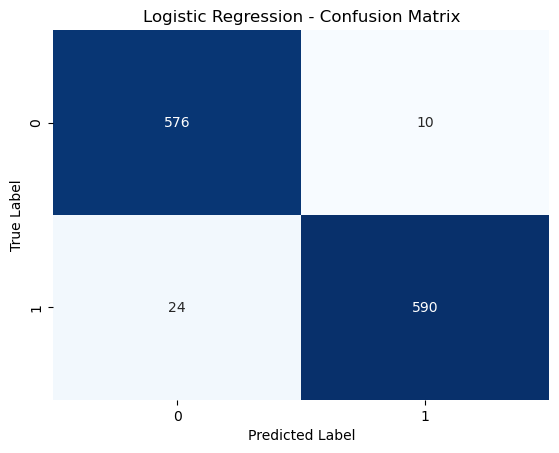

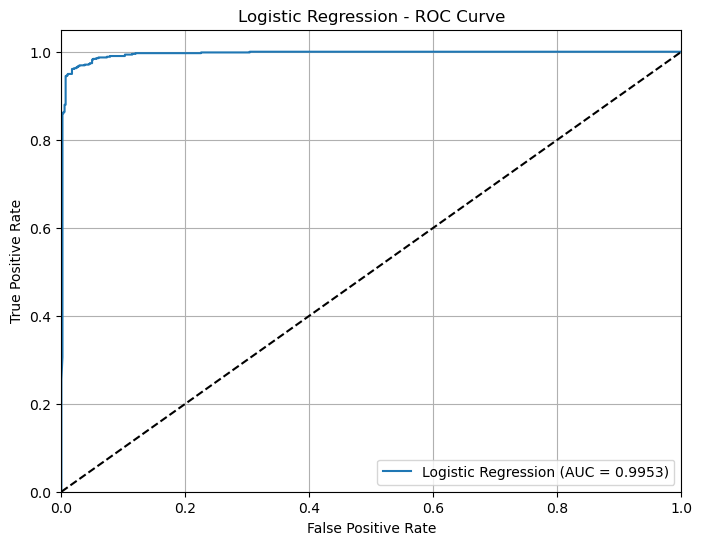

Logistic Regression Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97

Optimizing Decision Tree...
Best Parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


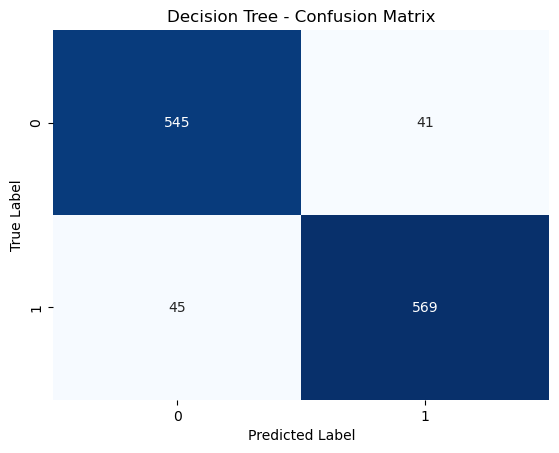

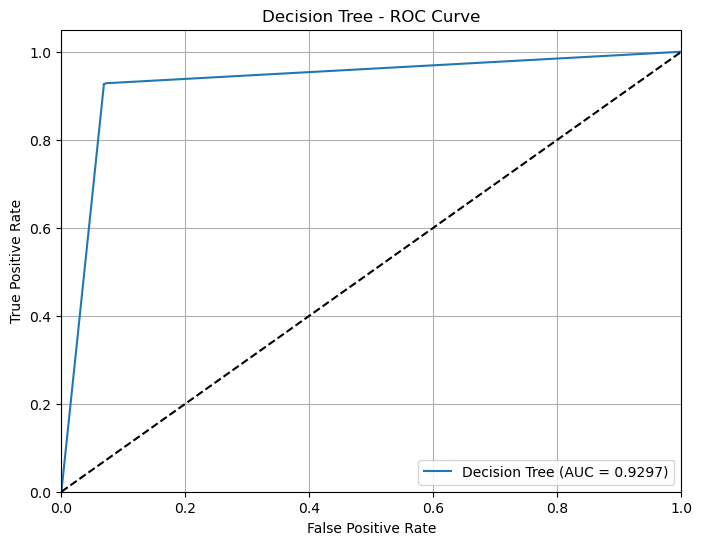

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.93
TNR (Specificity): 0.93
F1 Score: 0.93

Optimizing SVM...


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_clas

Best Parameters for LinearSVC: {'C': 1}


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


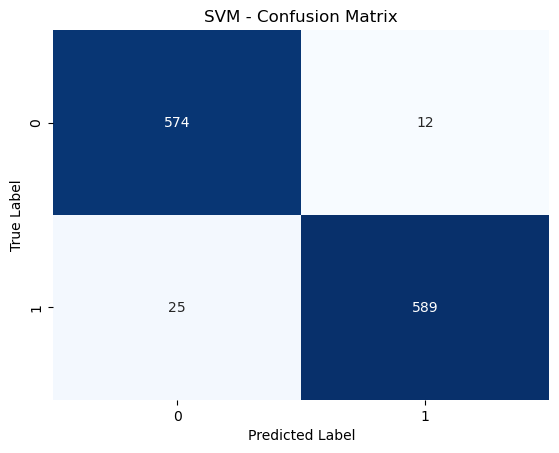

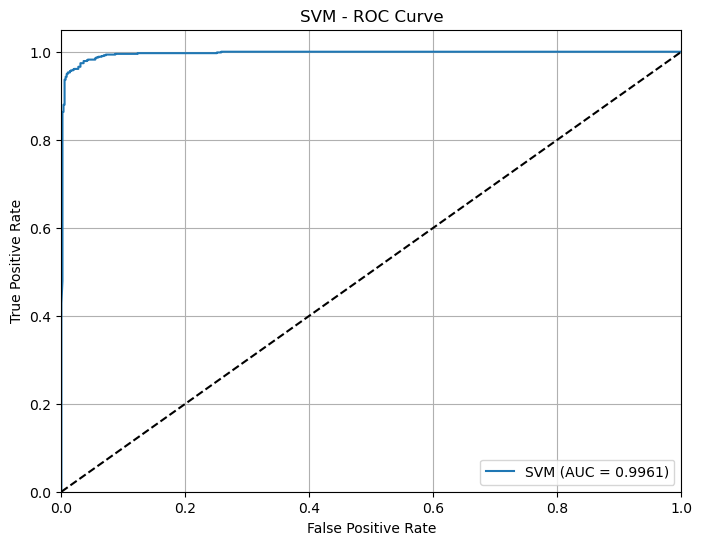

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97

Optimizing Random Forest...
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


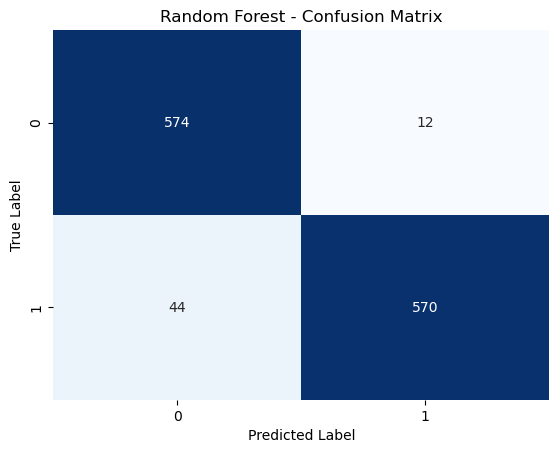

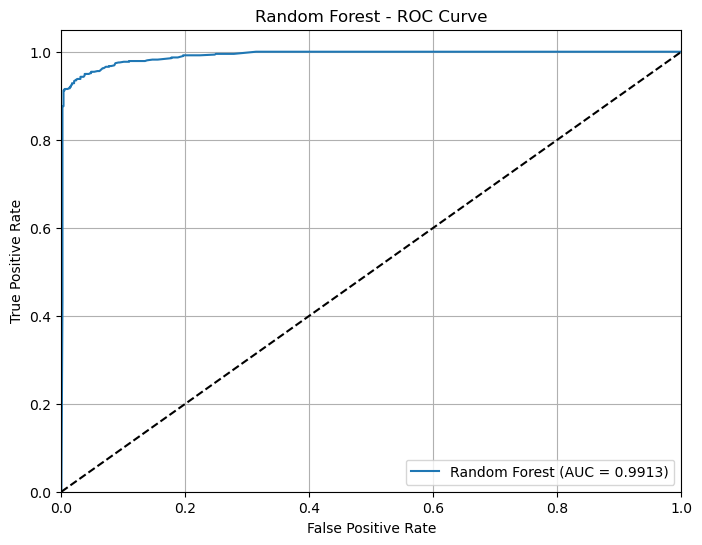

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95

Optimizing MLPClassifier...


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

In [25]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

def optimize_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=1)  # Daha az paralel işlem
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

def train_and_evaluate_models(X_train, X_test, y_train, y_test, include_nb=True):
    models = {
        'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000), {
            'C': [0.01, 0.1, 1, 10]
        }),
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }),
        'SVM': (LinearSVC(random_state=42, max_iter=1000), {
            'C': [0.01, 0.1, 1, 10]
        }),
        'Random Forest': (RandomForestClassifier(random_state=42, n_estimators=100), {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }),
        'MLPClassifier': (MLPClassifier(random_state=42, max_iter=300), {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['constant', 'adaptive']
        })
    }

    if include_nb:
        models['Naive Bayes'] = (MultinomialNB(), {
            'alpha': [0.01, 0.1, 1]
        })

    results = []

    for model_name, (model, param_grid) in models.items():
        print(f"Optimizing {model_name}...")
        best_model = optimize_model(model, param_grid, X_train, y_train)
        y_pred = best_model.predict(X_test)
        metrics = evaluate_model(y_test, y_pred, model_name, best_model, X_test)
        results.append(metrics)
        gc.collect()  # Belleği serbest bırak

    return pd.DataFrame(results)

print("Training and Evaluating Models...")

# Model eğitimi ve değerlendirme (Normalization, Standardization, Min-Max Scaling kaldırıldı)
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Sonuçları göster
print(results)

# Karşılaştırma Grafiği
plt.figure(figsize=(14, 8))
sns.barplot(data=results, x='Model', y='Accuracy')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Tüm metrikler için karşılaştırma grafiği
metrics = ['Accuracy', 'Precision', 'Recall (TPR)', 'TNR (Specificity)', 'F1 Score']
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(data=results, x='Model', y=metric, ax=axes[idx])
    axes[idx].set_title(f'Model Performance Comparison by {metric}')
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()


Training and Evaluating Models...
Optimizing Logistic Regression...
Best Parameters for LogisticRegression: {'C': 10}


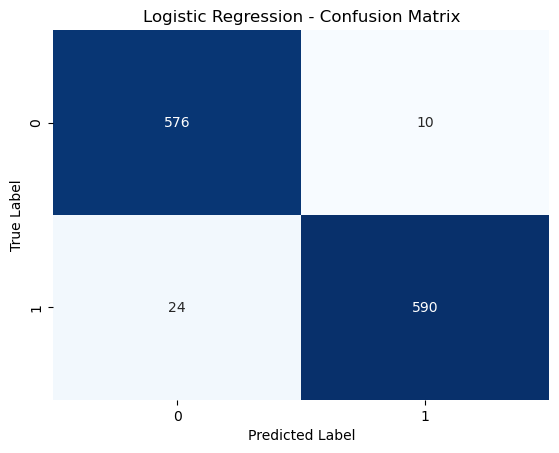

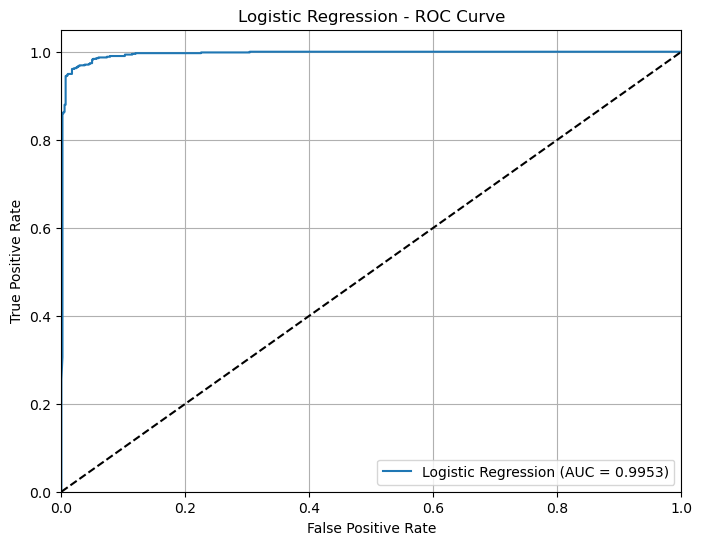

Logistic Regression Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97

Optimizing Decision Tree...
Best Parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


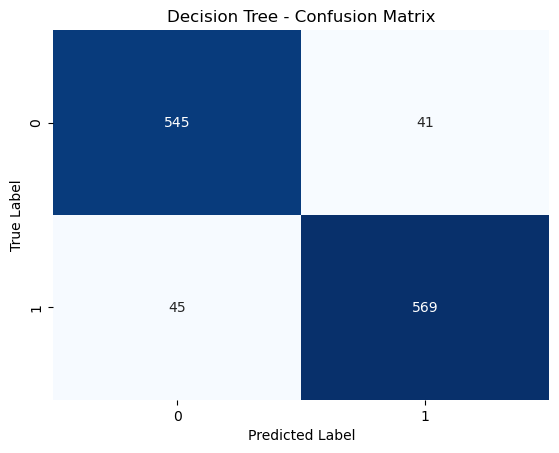

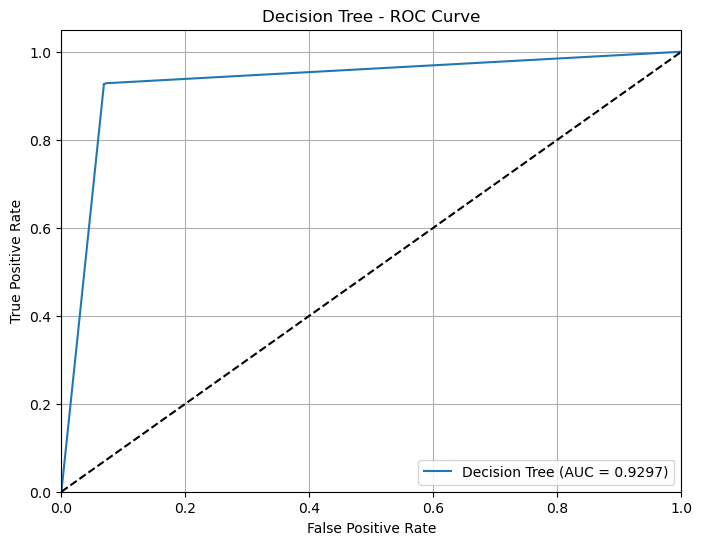

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.93
TNR (Specificity): 0.93
F1 Score: 0.93

Optimizing SVM...


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_clas

Best Parameters for LinearSVC: {'C': 1}


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


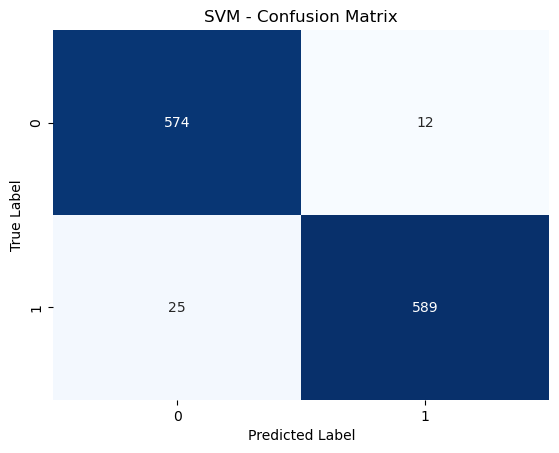

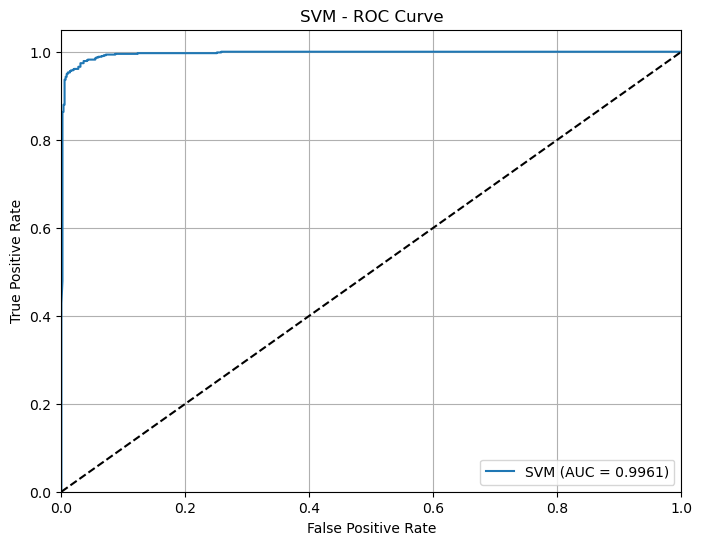

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97

Optimizing Random Forest...
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


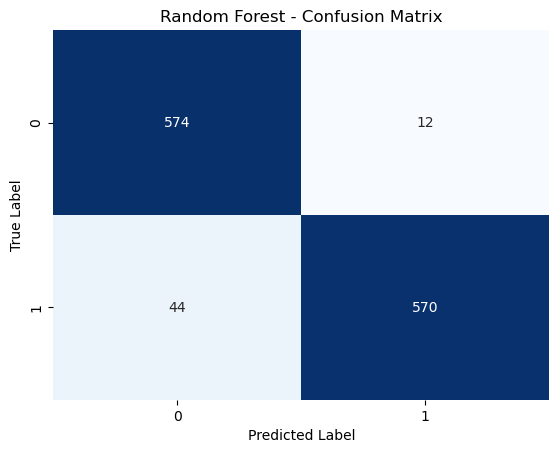

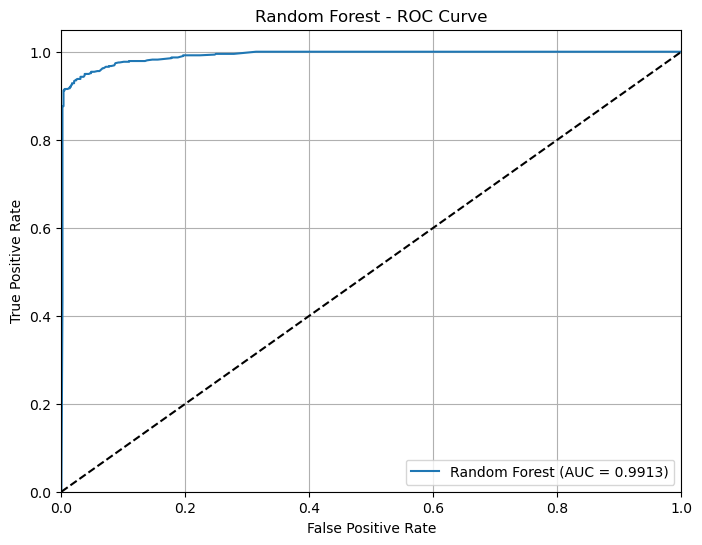

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95

Optimizing Naive Bayes...
Best Parameters for MultinomialNB: {'alpha': 0.01}


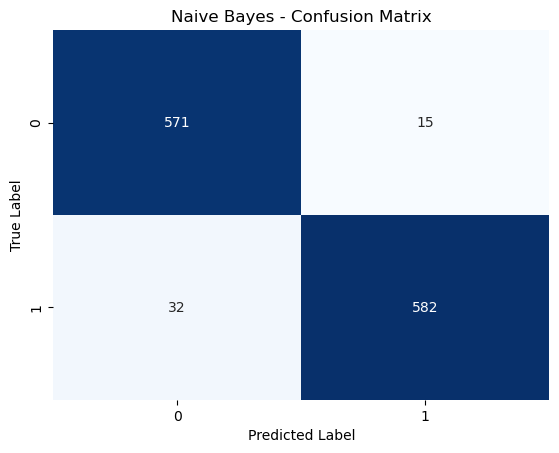

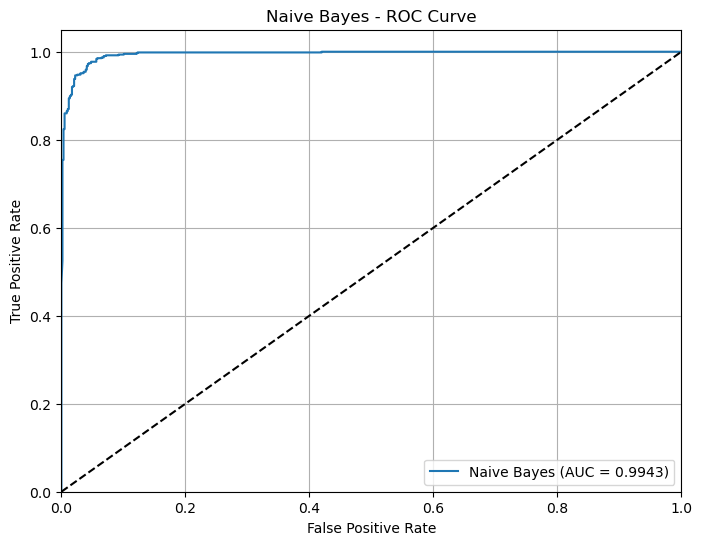

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Naive Bayes Performance:
Accuracy: 0.96
Precision: 0.97
Recall (TPR): 0.95
TNR (Specificity): 0.97
F1 Score: 0.96

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.971667   0.983333      0.960912           0.982935   
1        Decision Tree  0.928333   0.932787      0.926710           0.930034   
2                  SVM  0.969167   0.980033      0.959283           0.979522   
3        Random Forest  0.953333   0.979381      0.928339           0.979522   
4          Naive Bayes  0.960833   0.974874      0.947883           0.974403   

   F1 Score  
0  0.971993  
1  0.929739  
2  0.969547  
3  0.953177  
4  0.961189  


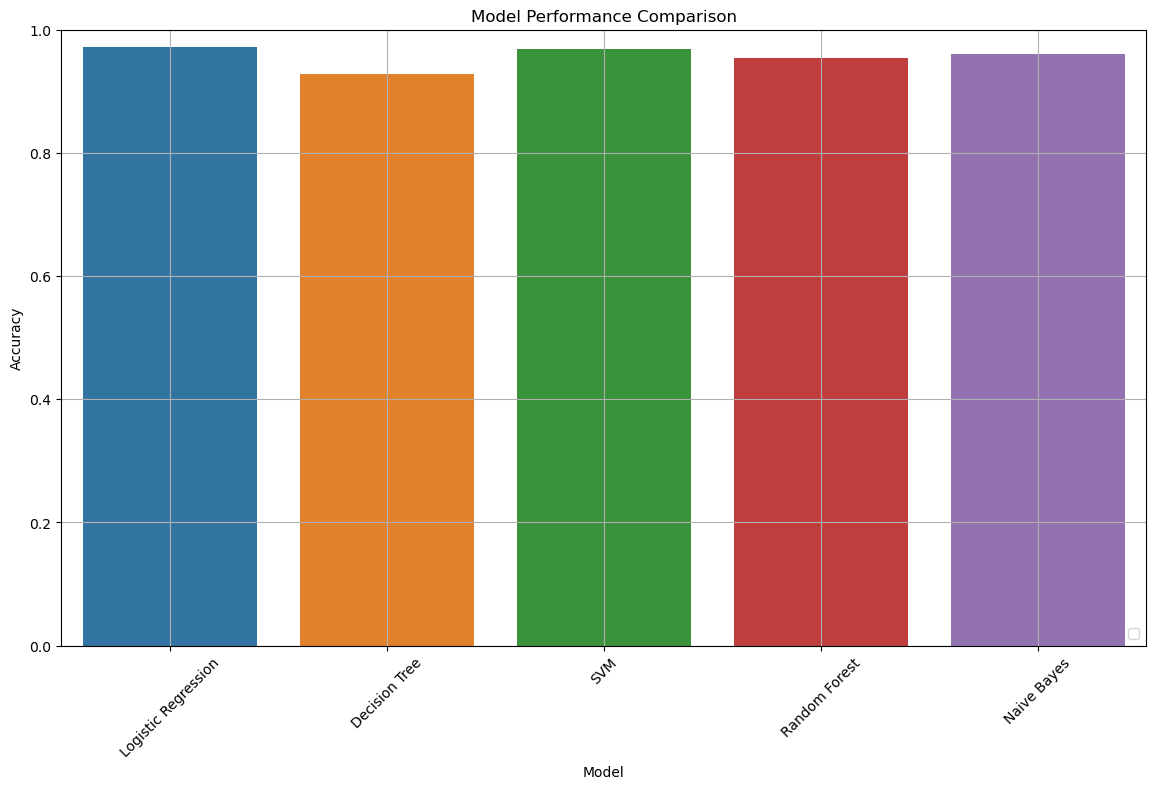

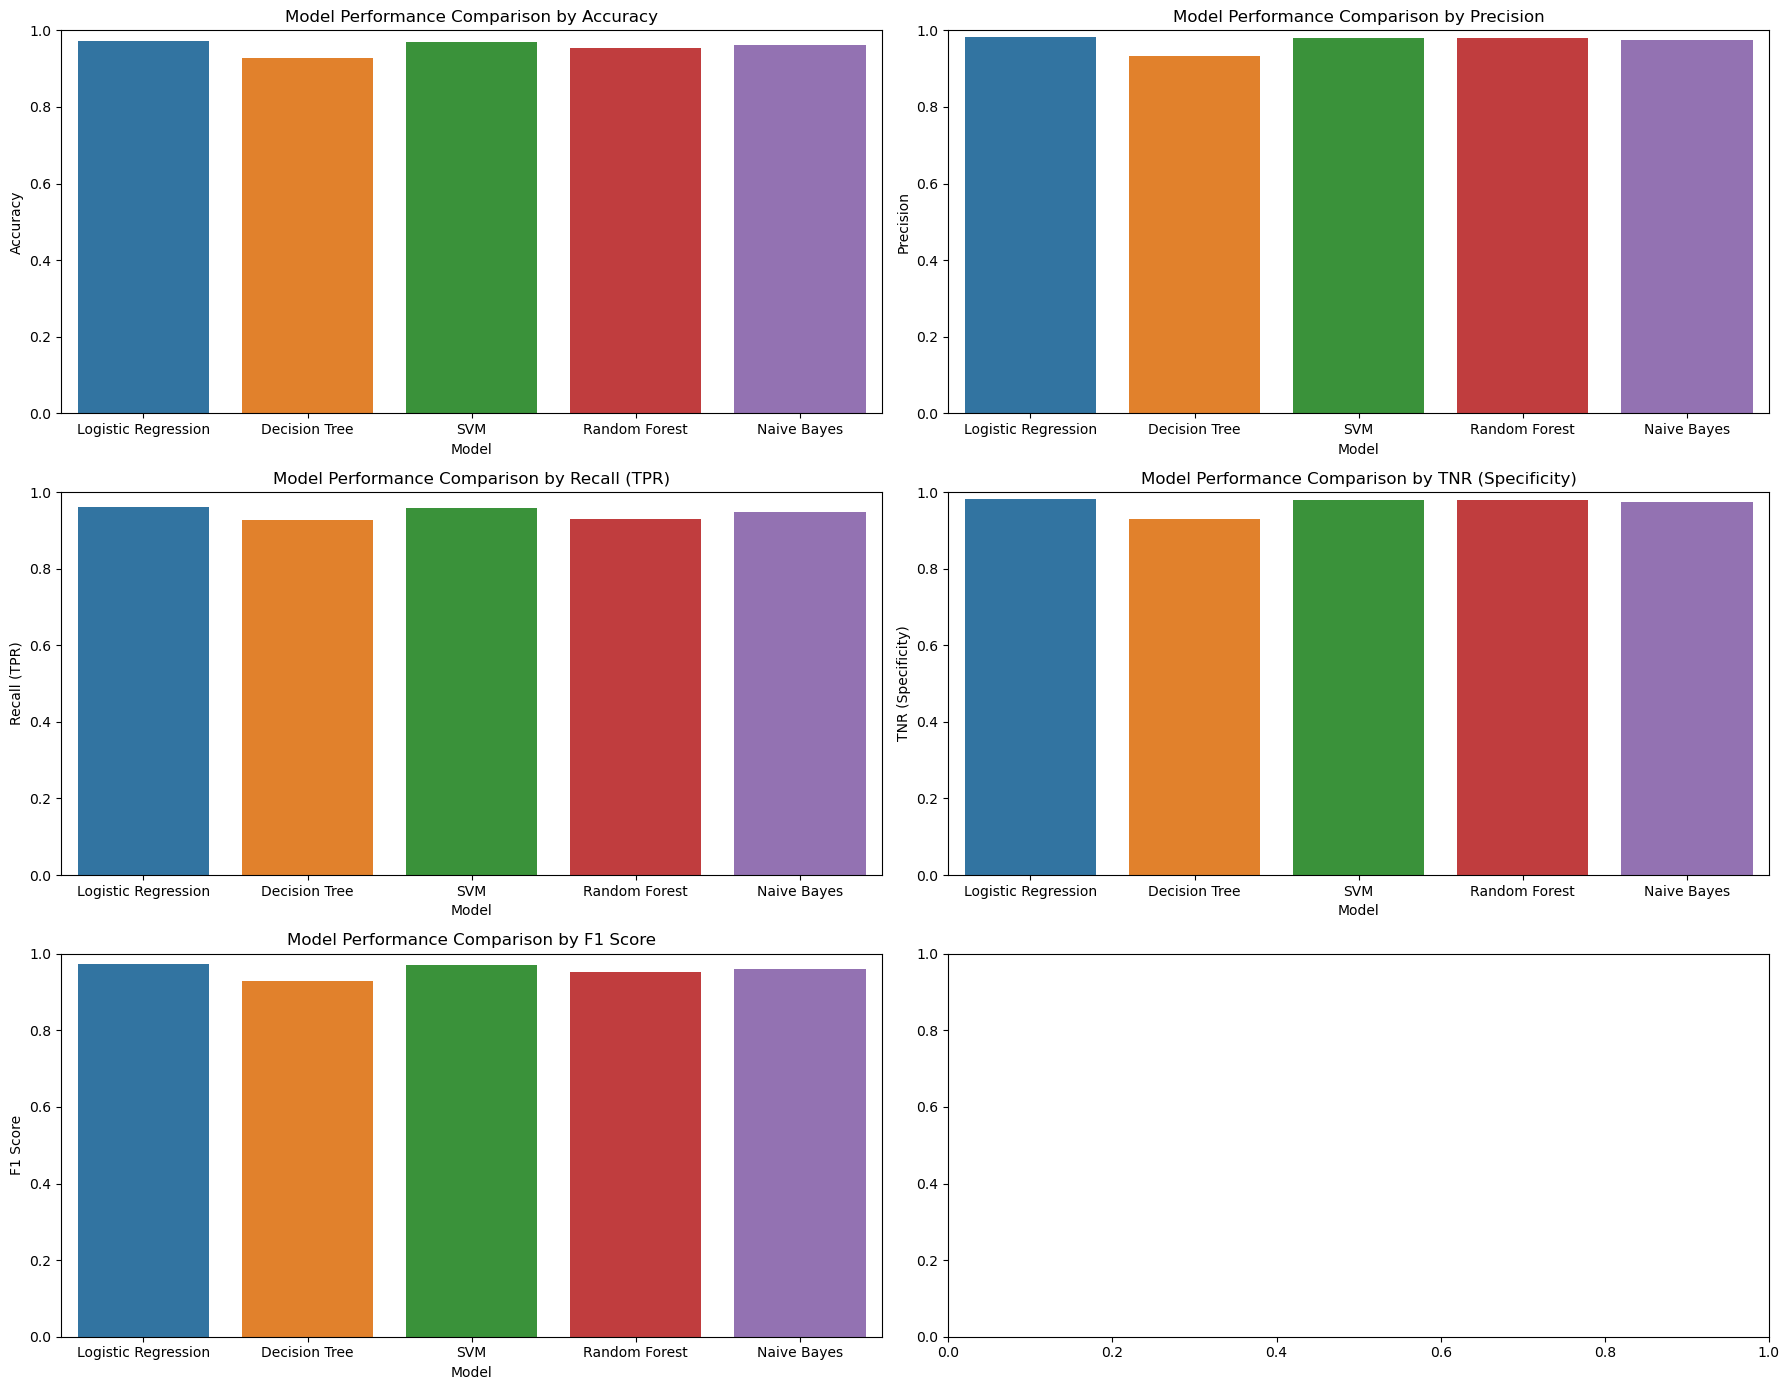

In [10]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

def optimize_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=1)  # Daha az paralel işlem
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

def train_and_evaluate_models(X_train, X_test, y_train, y_test, include_nb=True):
    models = {
        'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000), {
            'C': [0.01, 0.1, 1, 10]
        }),
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }),
        'SVM': (LinearSVC(random_state=42, max_iter=1000), {
            'C': [0.01, 0.1, 1, 10]
        }),
        'Random Forest': (RandomForestClassifier(random_state=42, n_estimators=100), {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        })
    }

    if include_nb:
        models['Naive Bayes'] = (MultinomialNB(), {
            'alpha': [0.01, 0.1, 1]
        })

    results = []

    for model_name, (model, param_grid) in models.items():
        print(f"Optimizing {model_name}...")
        best_model = optimize_model(model, param_grid, X_train, y_train)
        y_pred = best_model.predict(X_test)
        metrics = evaluate_model(y_test, y_pred, model_name, best_model, X_test)
        results.append(metrics)
        gc.collect()  # Belleği serbest bırak

    return pd.DataFrame(results)

print("Training and Evaluating Models...")

# Model eğitimi ve değerlendirme
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Sonuçları göster
print(results)

# Karşılaştırma Grafiği
plt.figure(figsize=(14, 8))
sns.barplot(data=results, x='Model', y='Accuracy')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Tüm metrikler için karşılaştırma grafiği
metrics = ['Accuracy', 'Precision', 'Recall (TPR)', 'TNR (Specificity)', 'F1 Score']
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(data=results, x='Model', y=metric, ax=axes[idx])
    axes[idx].set_title(f'Model Performance Comparison by {metric}')
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()
